# Сборный проект — 2

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 
У вас будет несколько задач. Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
Ваша вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

# Задача 1: предсказание уровня удовлетворённости сотрудника
Для этой задачи заказчик предоставил данные с признаками:
* `id` — уникальный идентификатор сотрудника;
* `dept` — отдел, в котором работает сотрудник;
* `level` — уровень занимаемой должности;
* `workload` — уровень загруженности сотрудника;
* `employment_years` — длительность работы в компании (в годах);
* `last_year_promo` — показывает, было ли повышение за последний год;
* `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
* `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
* `salary` — ежемесячная зарплата сотрудника;
* `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

## Загрузка данных

In [1]:
!pip install -Uq scikit-learn
!pip install phik
!pip install shap

In [2]:
# загружаем необходимые библиотеки и классы
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import warnings
import phik
import shap

from sklearn.preprocessing import (OneHotEncoder, 
                                    OrdinalEncoder, 
                                    StandardScaler, 
                                    MinMaxScaler, 
                                    RobustScaler, 
                                    LabelEncoder
                                    )
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.metrics import (
                            f1_score,
                            fbeta_score,
                            mean_absolute_error,
                            mean_squared_error,
                            r2_score,
                            roc_auc_score,
                            recall_score,
                            precision_score,
                            accuracy_score,
                            confusion_matrix,
                            make_scorer)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats as st
from scipy.stats import shapiro
from sklearn.metrics import classification_report
from phik.report import plot_correlation_matrix
from phik import report 

In [3]:
warnings.filterwarnings('ignore') # скроем лишние предупреждения

In [4]:
# загружаем данные
try:
    df_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    X_test = pd.read_csv('/datasets/test_features.csv')
    y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    df_train = pd.read_csv('train_job_satisfaction_rate.csv')
    X_test = pd.read_csv('test_features.csv')
    y_test = pd.read_csv('test_target_job_satisfaction_rate.csv')

**Вывод:** данные и необходимые библиотеки были загружены.

## Предобработка данных

In [5]:
# функция для описания датасета
def df_describe(df):
    display(df.head(10))
    print('Общая информация о полученном датафрейме:')
    df.info()
    print('Описание данных:')
    display(df.describe())
    print('Количество пустых значений:')
    display(df.isna().sum())
    print('Количество явных дубликатов:')
    display(df.duplicated().sum())

In [6]:
df_describe(df_train) 

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


Общая информация о полученном датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
Описание данных:


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


Количество пустых значений:


id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Количество явных дубликатов:


0

In [7]:
# проверяем уникальные значения в строковых данных
columns = list(df_train.select_dtypes(include=['object']).columns)

for col in columns:
    print(df_train[col].unique())

['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['junior' 'middle' 'sinior' nan]
['medium' 'high' 'low']
['no' 'yes']
['no' 'yes']


In [8]:
# заменим некорректное значение 'sinior'
df_train['level'] = df_train['level'].replace('sinior', 'senior')
df_train['level'].value_counts()

junior    1894
middle    1744
senior     358
Name: level, dtype: int64

In [9]:
# установим id работника как индекс
df_train = df_train.set_index('id')
df_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


Названия столбцов и значения признаков записаны в соответсвии с PEP8. Все типы данных соответсвуют значениям. Имеются несколько пропусков в признаках `dept` (6) и `level` (4). В соответсвии с требованиями заполним данные пропуски поздней в пайплайне. Явные и неявные дубликаты отсутсвуют. Исправлена опечатка в уровне сотрудника. id сотркдника установлен как индекс. 

In [10]:
df_describe(X_test) 

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


Общая информация о полученном датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
Описание данных:


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Количество пустых значений:


id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Количество явных дубликатов:


0

In [11]:
# проверяем уникальные значения в строковых данных
columns = list(X_test.select_dtypes(include=['object']).columns)

for col in columns:
    print(X_test[col].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


In [12]:
# заменим некорректное значение 'sinior'
X_test['level'] = X_test['level'].replace('sinior', 'senior')
X_test['level'].value_counts()

junior    974
middle    854
senior    171
Name: level, dtype: int64

In [13]:
# установим id работника как индекс
X_test = X_test.set_index('id')
X_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


Названия столбцов и значения признаков записаны в соответсвии с PEP8. Все типы данных соответсвуют значениям. Имеются несколько пропусков в признаках `dept` (6) и `level` (4). В соответсвии с требованиями заполним данные пропуски поздней в пайплайне. Явные и неявные дубликаты отсутсвуют. Исправлена опечатка в уровне сотрудника. id сотркдника установлен как индекс. 

In [14]:
df_describe(y_test)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


Общая информация о полученном датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
Описание данных:


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


Количество пустых значений:


id                       0
job_satisfaction_rate    0
dtype: int64

Количество явных дубликатов:


0

In [15]:
y_test = y_test.set_index('id')
y_test.head()

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


**Вывод:** Названия столбцов и значения признаков записаны в соответсвии с PEP8. Все типы данных соответсвуют значениям. Имеются несколько пропусков в признаках `dept` (6) и `level` (4). В соответсвии с требованиями заполним данные пропуски поздней в пайплайне. Явные и неявные дубликаты отсутсвуют. Исправлена опечатка в уровне сотрудника. id сотркдника установлен как индекс. В датасете test_target_job_satisfaction_rate аномалий не отмечено.

## Исследовательский анализ данных

In [16]:
# напишем функция для визуализации количественных признаков
def viz_col(df, feature):
    discrete_features = [col for col in df.columns if df[col].nunique() < 20]
    continuous_features = [col for col in df.select_dtypes(include=['number']).columns if col not in discrete_features]

    if feature in discrete_features:
        print(f'Количество сотрудников по признаку "{feature}":')
        display(df[feature].value_counts())
        
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=feature)
        plt.title(f'Распределение сотрудников по признаку "{feature}"', fontsize=15)
        plt.xlabel(f'Признак "{feature}"', fontsize=14)
        plt.ylabel('Количество', fontsize=14)
        plt.show()
    
    else:
        print(f'Описательная статистика для признака "{feature}":')
        display(df[feature].describe())
        
        plt.figure(figsize=(20, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df[feature], kde=True, bins=50)
        plt.title(f'Распределение сотрудников по признаку "{feature}"', fontsize=15)
        plt.xlabel(f'Признак "{feature}"', fontsize=14)
        plt.ylabel('Плотность распределения', fontsize=14)
        
        plt.subplot(1, 2, 2)
        sns.boxplot(df[feature])
        plt.title(f'Диаграмма размаха по признаку "{feature}"', fontsize=15)
        plt.xlabel(f'Значения признака "{feature}"', fontsize=14)
        
        plt.tight_layout()
        plt.show()

In [17]:
# функция для визуализация категориальных признаков
def viz_cat(df, feature):
    print(f'Количество сотрудников по признаку "{feature}":')
    display(df[feature].value_counts())
    
    plt.figure(figsize=(20, 6))
    
    plt.subplot(1, 2, 1)
    sns.countplot(x = feature, data = df)
    plt.title(f'Распределение сотрудников по признаку "{feature}"', fontsize=15)
    plt.xlabel(f'Признак "{feature}"', fontsize=14)
    plt.xticks(rotation=45)
    plt.ylabel('Кол-во покупателей', fontsize=14)

    
    plt.subplot(1, 2, 2)
    df.groupby(feature)[feature].count().plot(kind='pie', autopct='%.1f%%', subplots=True)
    plt.title(f'Круговая диаграмма по признаку "{feature}"', fontsize=15)
    plt.ylabel("")
    
    plt.tight_layout()
    plt.show()

Количество сотрудников по признаку "employment_years":


1     966
2     785
3     483
4     384
5     380
7     301
6     287
8     193
9     130
10     91
Name: employment_years, dtype: int64

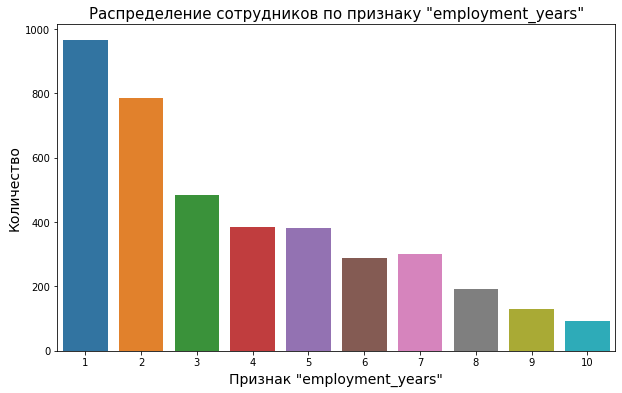

Количество сотрудников по признаку "supervisor_evaluation":


4    1603
3    1263
5     546
2     387
1     201
Name: supervisor_evaluation, dtype: int64

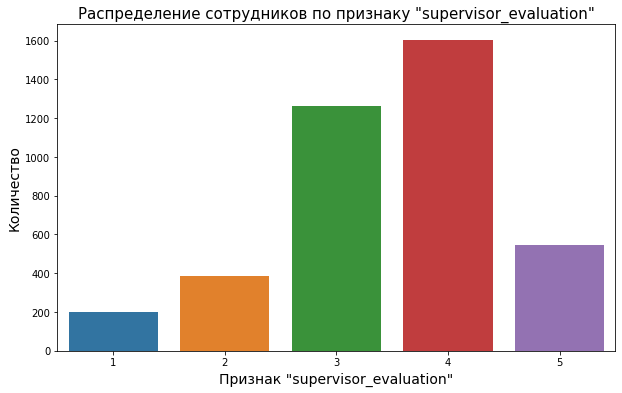

Описательная статистика для признака "salary":


count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

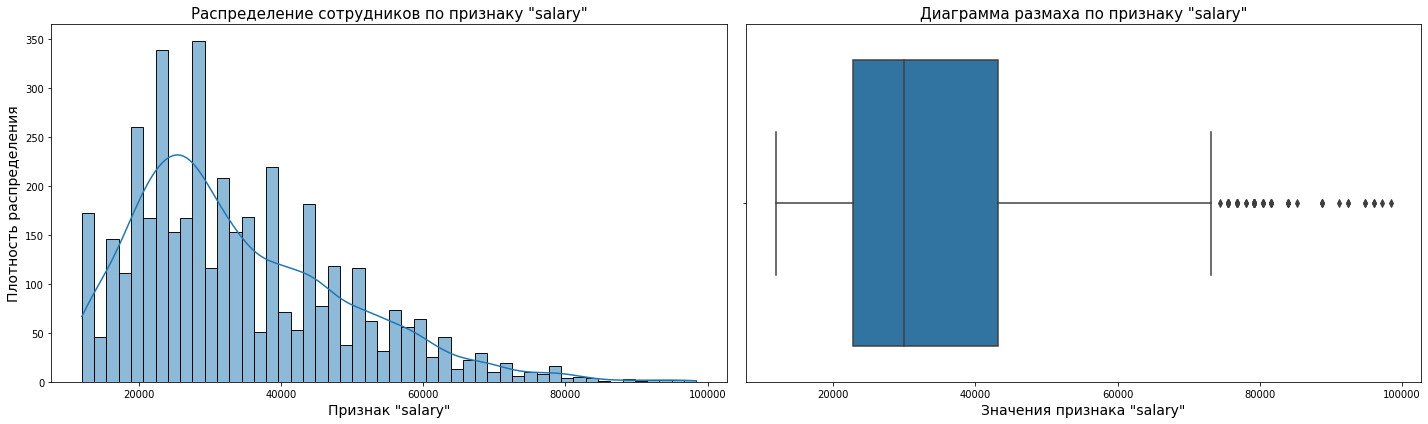

Описательная статистика для признака "job_satisfaction_rate":


count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

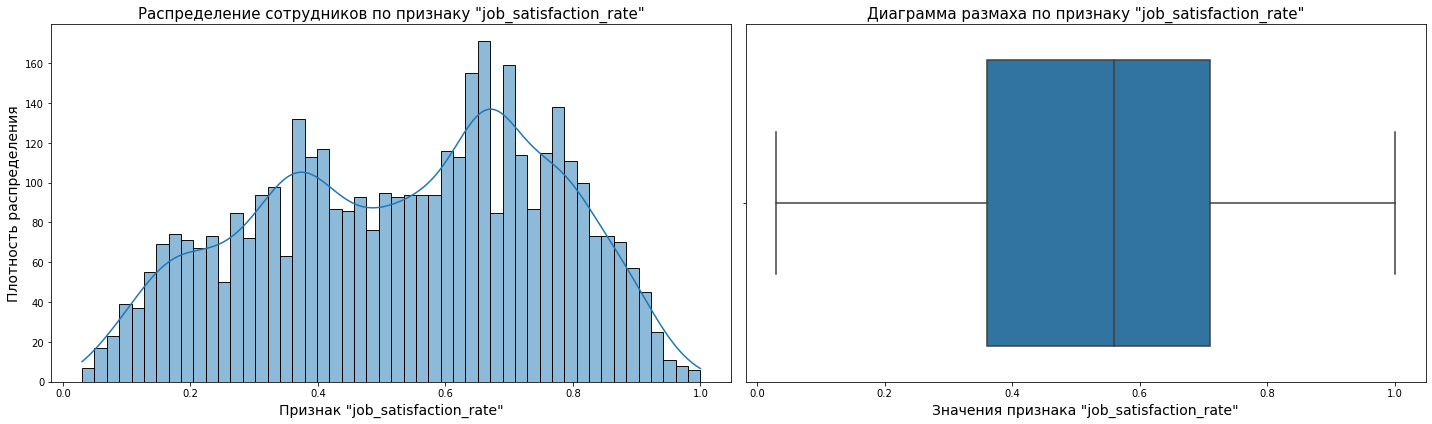

In [18]:
num_features = list(df_train.select_dtypes(exclude=['object']).columns)

for num in num_features:
    viz_col(df_train, num)

Распрделение сотрудников по признаку `employment_years`логично - сотрудников работающих в компании несколько лет меньше, чем новичков. Руководители в основном ставили сотрудникам оценку 4. В среднем сотрудники получают 34000. В целевом признаки отсутсвуют выбросы, распределение близко к бимодальному.

Количество сотрудников по признаку "dept":


sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

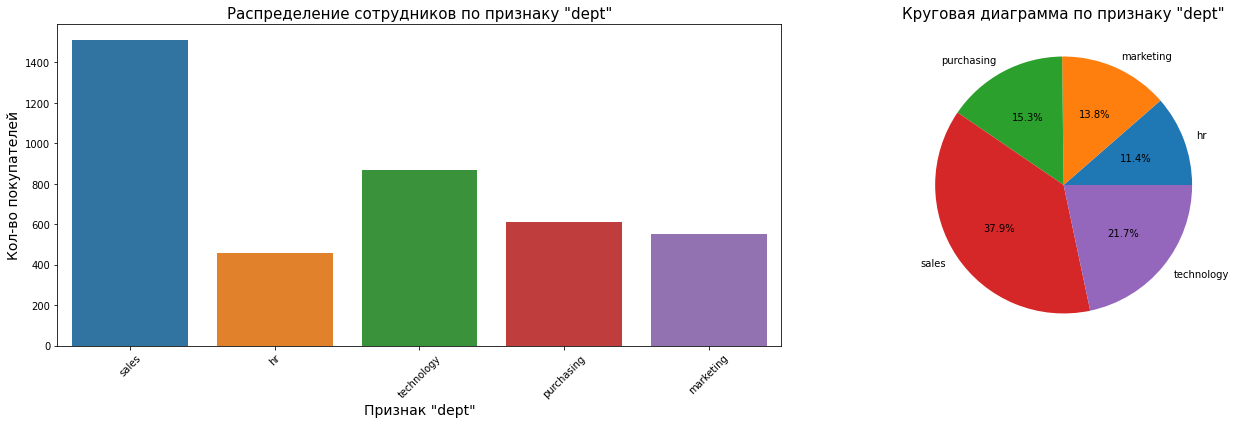

Количество сотрудников по признаку "level":


junior    1894
middle    1744
senior     358
Name: level, dtype: int64

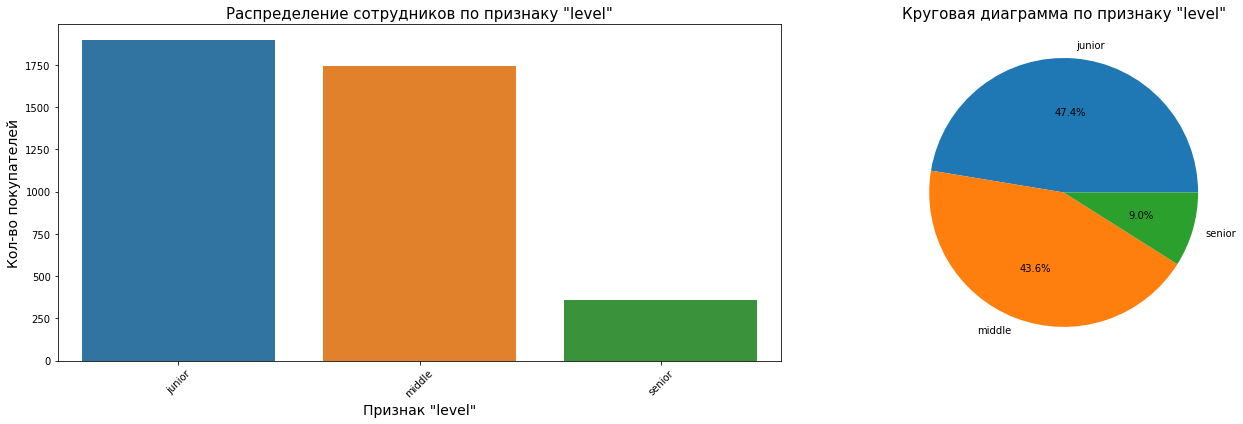

Количество сотрудников по признаку "workload":


medium    2066
low       1200
high       734
Name: workload, dtype: int64

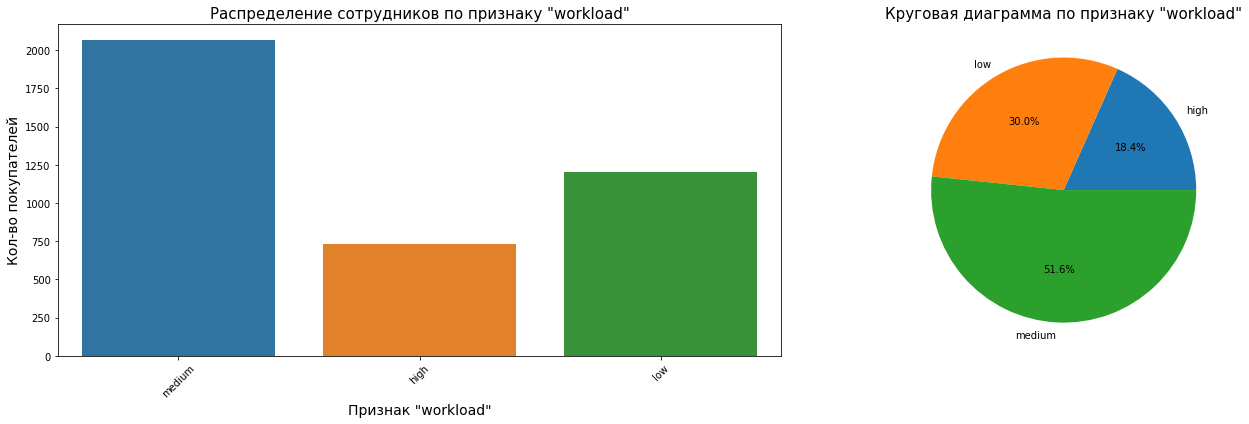

Количество сотрудников по признаку "last_year_promo":


no     3880
yes     120
Name: last_year_promo, dtype: int64

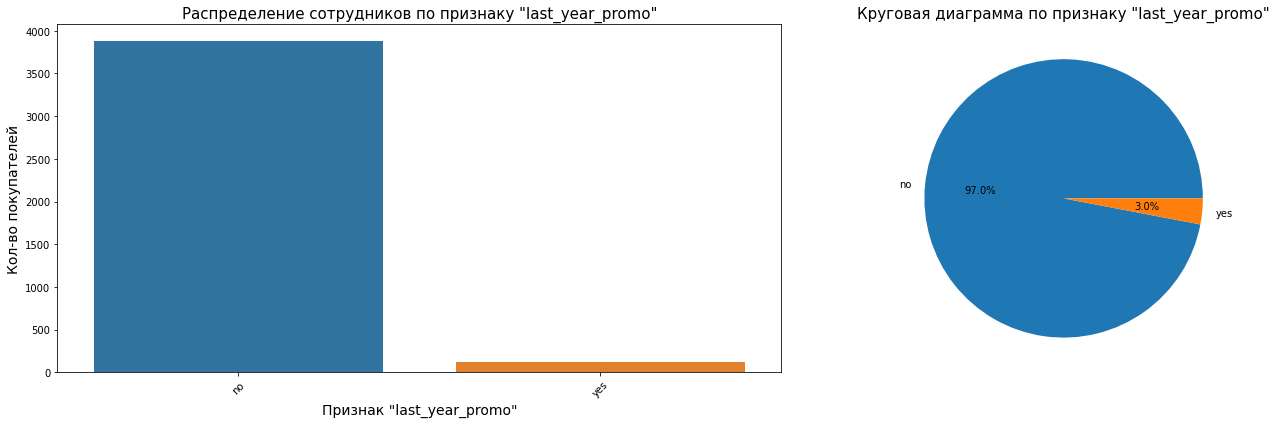

Количество сотрудников по признаку "last_year_violations":


no     3441
yes     559
Name: last_year_violations, dtype: int64

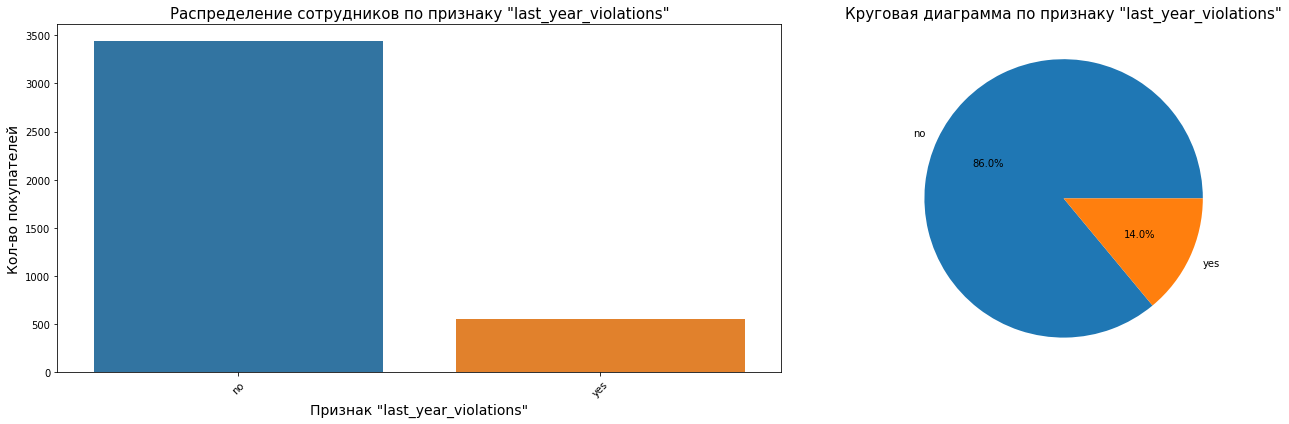

In [19]:
cat_features = list(df_train.select_dtypes(include=['object']).columns)

for cat in cat_features:
    viz_cat(df_train, cat)

Больше всего сотрудников наблюдается в отделе продаж. Сотрудник уровня 'junior' больше всего. Среднее количество нагрузки отмечено у 2066 сотрудников. Повышение за последний год получили 120 сотрудников (3%). 449 человек (14%) нарушали трудовой договор за последний год. 

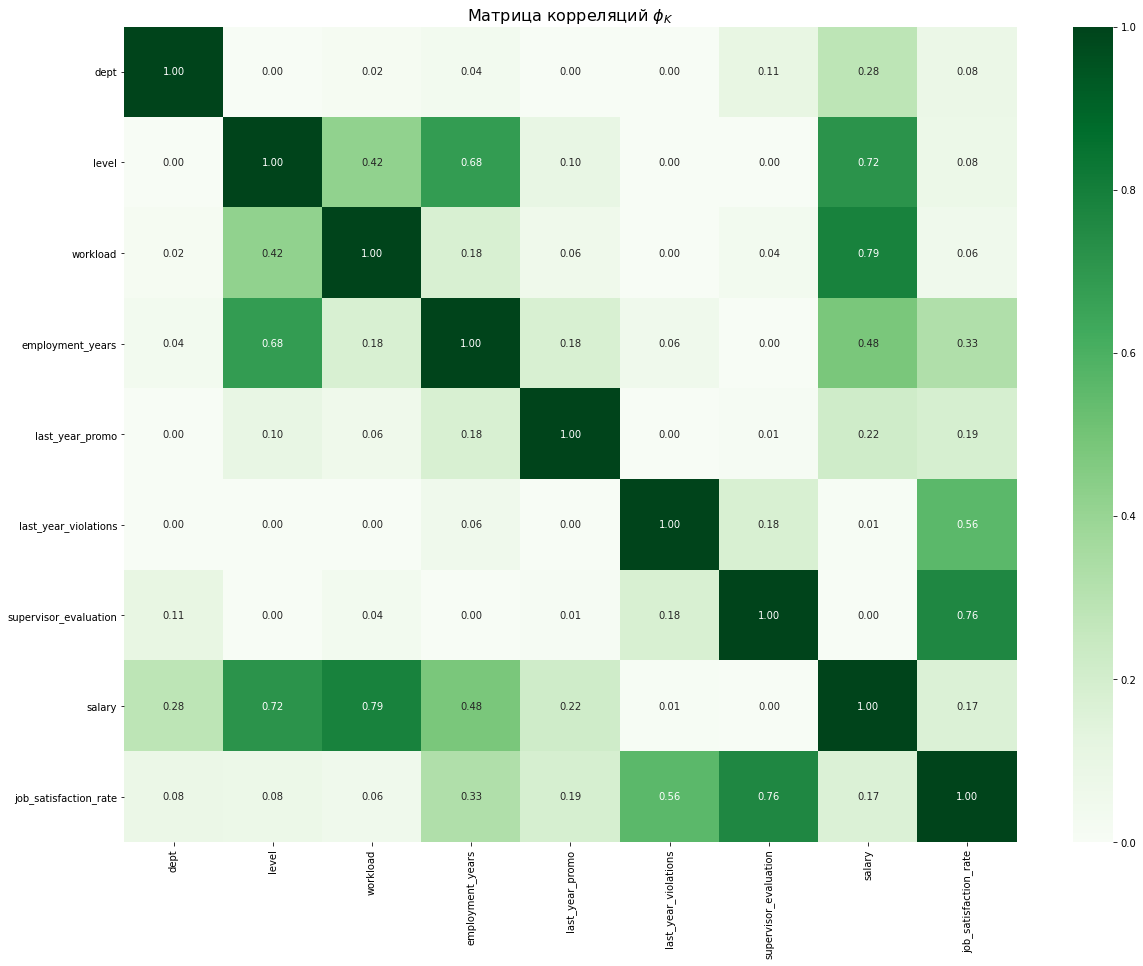

In [20]:
interval_cols = ['job_satisfaction_rate', 'salary']

corr = df_train.phik_matrix(interval_cols=interval_cols, verbose=False)

plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, cmap='Greens', fmt='.2f') 
plt.title(r'Матрица корреляций $\phi_K$', fontsize=16)
plt.show()

Мультиколлинеарности не наблюдается. С целевым признаком имеют корреляцию такие признаки как `supervisor_evaluation` (0.76), `last_year_violations` (0.56), `employment_years` (0.33)  и `last_year_promo` (0.19).

Количество сотрудников по признаку "employment_years":


1     522
2     374
3     234
4     187
5     179
7     174
6     138
8      91
9      66
10     35
Name: employment_years, dtype: int64

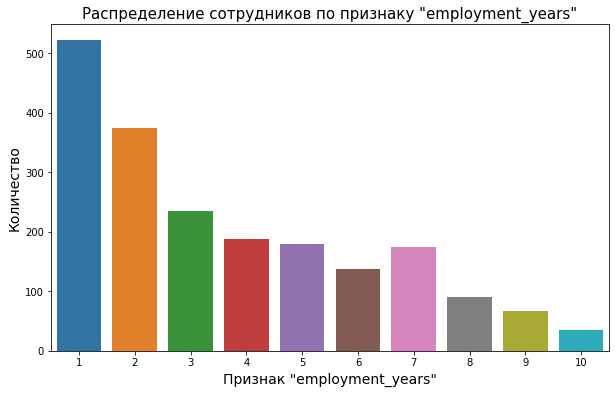

Количество сотрудников по признаку "supervisor_evaluation":


4    857
3    575
5    284
2    196
1     88
Name: supervisor_evaluation, dtype: int64

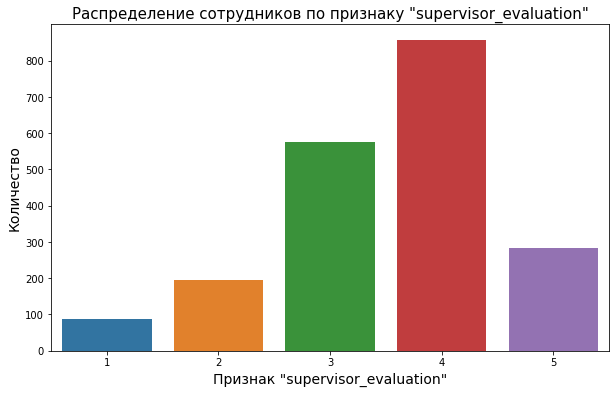

Описательная статистика для признака "salary":


count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

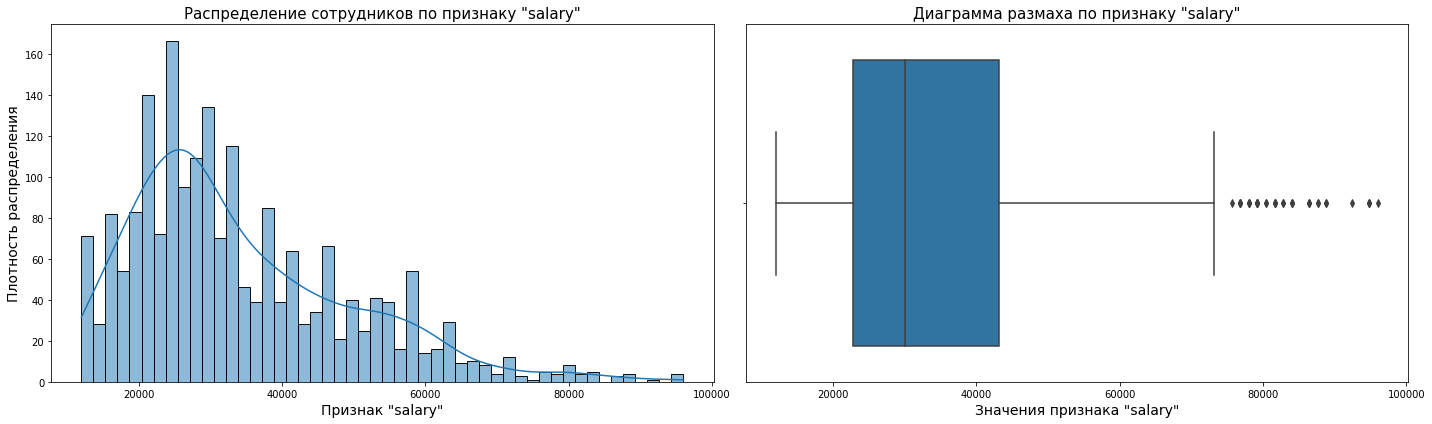

In [21]:
num_features = list(X_test.select_dtypes(exclude=['object']).columns)

for num in num_features:
    viz_col(X_test, num)

Количество сотрудников по признаку "dept":


sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

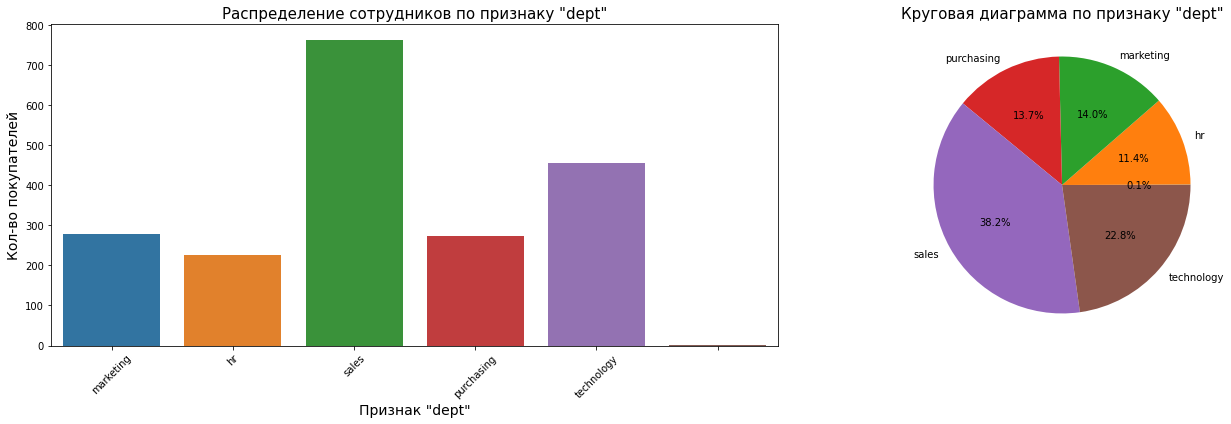

Количество сотрудников по признаку "level":


junior    974
middle    854
senior    171
Name: level, dtype: int64

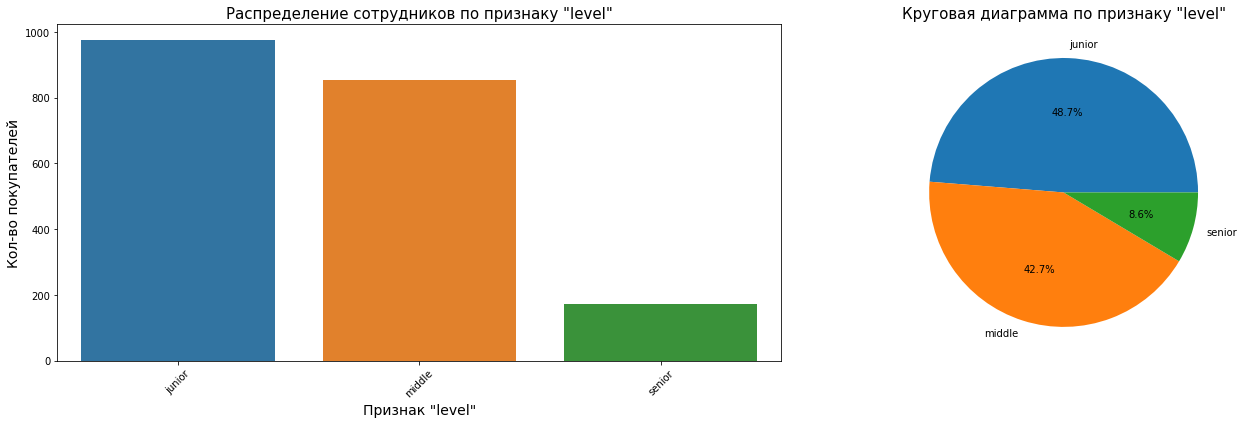

Количество сотрудников по признаку "workload":


medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

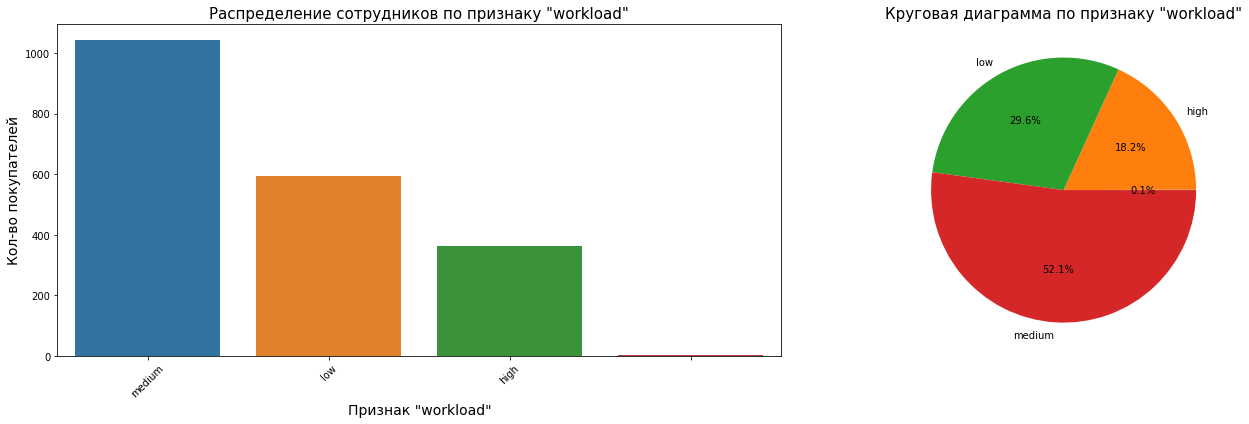

Количество сотрудников по признаку "last_year_promo":


no     1937
yes      63
Name: last_year_promo, dtype: int64

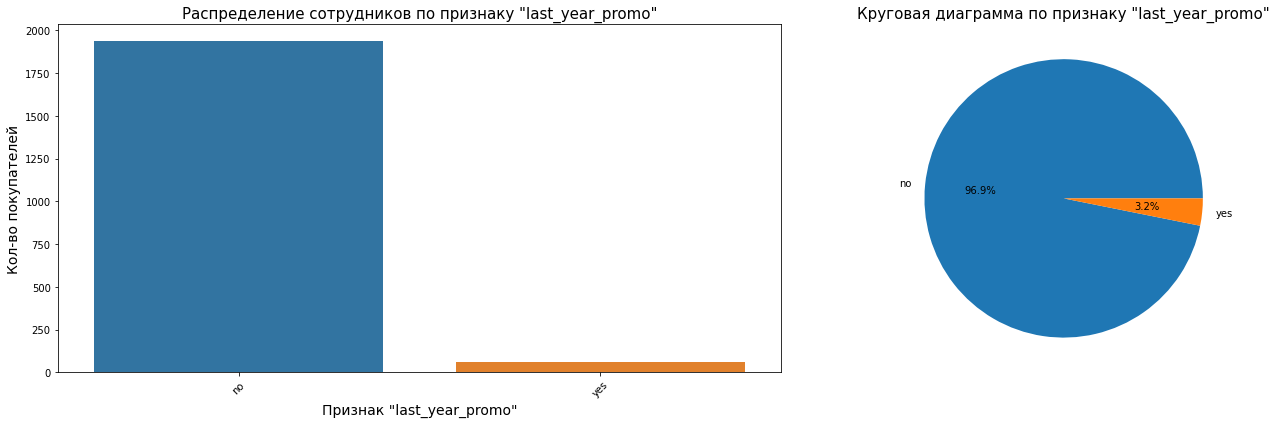

Количество сотрудников по признаку "last_year_violations":


no     1738
yes     262
Name: last_year_violations, dtype: int64

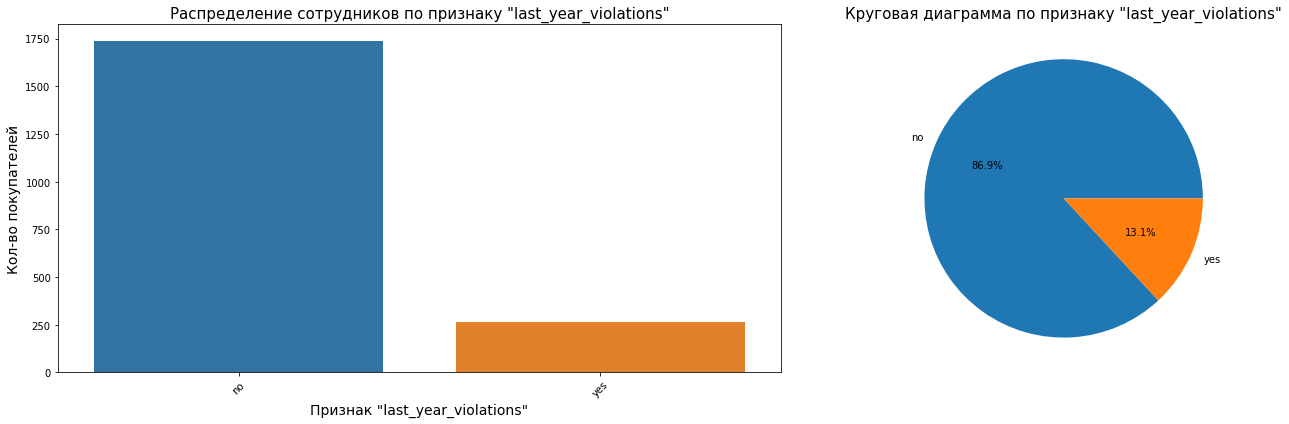

In [22]:
cat_features = list(X_test.select_dtypes(include=['object']).columns)

for cat in cat_features:
    viz_cat(X_test, cat)

Значения признаков в тестовой обучающей выборке схожи с тренировочными данными.

Описательная статистика для признака "job_satisfaction_rate":


count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

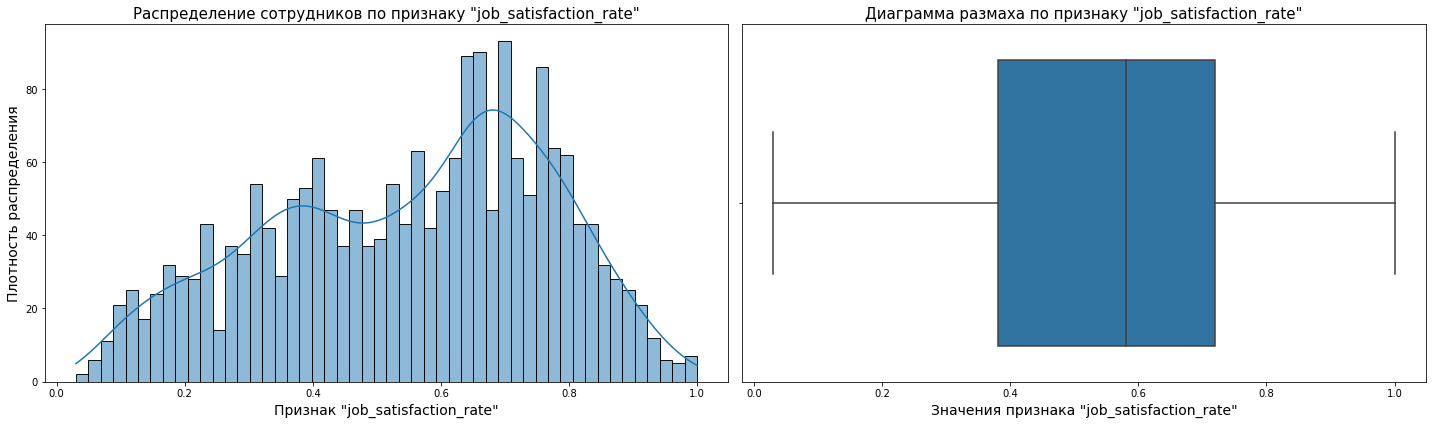

In [23]:
viz_col(y_test, 'job_satisfaction_rate')

В соответсвии с тестовой выборкой 564 сотрудника (28.2%) покинули компанию.

**Вывод:** Больше всего сотрудников наблюдается в отделе продаж. Сотрудник уровня 'junior' больше всего. Среднее количество нагрузки отмечено у 2066 сотрудников. Повышение за последний год получили 120 сотрудников (3%). 449 человек (14%) нарушали трудовой договор за последний год. Мультиколлинеарности не наблюдается. С целевым признаком имеют корреляцию такие признаки как `supervisor_evaluation` (0.76), `last_year_violations` (0.56), `employment_years` (0.33)  и `last_year_promo` (0.19). Значения признаков в тестовой обучающей выборке схожи с тренировочными данными. В соответсвии с тетовой выборкой 564 сотрудника (28.2%) покинули компанию.

## Подготовка данных

In [24]:
# сопоставим тестовые данные
df_test = X_test.merge(y_test, on='id', how='left')
X_test = df_test.drop(['job_satisfaction_rate'],axis=1)
y_test = df_test['job_satisfaction_rate']
display(X_test.head())
display(y_test.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


id
485046    0.79
686555    0.72
467458    0.64
418655    0.60
789145    0.75
Name: job_satisfaction_rate, dtype: float64

In [25]:
# выделим целевой признак в тренировочных данных
X_train = df_train.drop('job_satisfaction_rate', axis=1)
y_train = df_train['job_satisfaction_rate']
display(X_train.head())
display(y_train.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000
653870,hr,junior,high,2,no,no,5,38400
184592,sales,junior,low,1,no,no,2,12000
171431,technology,junior,low,4,no,no,2,18000
693419,hr,junior,medium,1,no,no,3,22800


id
155278    0.58
653870    0.76
184592    0.11
171431    0.37
693419    0.20
Name: job_satisfaction_rate, dtype: float64

In [26]:
# определим списки для кодирования
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

num_columns = ['employment_years', 'salary','supervisor_evaluation']

ord_columns = ['level', 'workload']

In [27]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

In [28]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [29]:
data_preprocessor = ColumnTransformer([
    ('ohe',ohe_pipe,ohe_columns),
    ('ord',ord_pipe,ord_columns),
    ('num',StandardScaler(),num_columns)
],
remainder='passthrough')

**Вывод:** создан пайплайн для подготовки данных.

## Обучение моделей

In [30]:
# функция для метрики smape
def smape(y_pred, y_true):
    error = abs(y_true - y_pred)
    scale = (abs(y_true) + abs(y_pred)) / 2 + 0.000000001
    result = (error / scale).mean()*100
    return result
smape_scorer = make_scorer(smape, greater_is_better=False)

In [31]:
# создаём пайплайн: подготовка данных и модель
pipe_final = Pipeline(
[
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [32]:
RANDOM_STATE = 42

# словарь гиперпараметров
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=42)],
        'models__max_depth': range(1, 20),
        'models__min_samples_split': range(1, 20),
        'models__min_samples_leaf': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },

   {
       'models': [LinearRegression()],
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
   },
    
   {
       'models': [SVR()],
       'models__C': range(1, 10),
       'models__degree': range(1, 4),
       'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
   }
]

In [33]:
# автоматический подбор с помощью RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:', randomized_search.best_estimator_)
print('Мeтрика SMAPE для лучшей модели:', abs(randomized_search.best_score_))

Лучшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                     

Лучше всего себя показала модель DecisionTreeRegressor с гиперпараметрами max_depth=16, max_features=9, min_samples_leaf=3, random_state=42. Метрика SMAPE - 15.21.

In [34]:
# cоздание DummyRegressor с прогнозированием среднего значения
dummy_model = DummyRegressor(strategy="mean")

# обучение и кросс-валидация DummyRegressor на тренировочной выборке
dummy_smape_scores = cross_val_score(
    dummy_model, X_train, y_train, cv=5, scoring=smape_scorer
)

# вывод среднего значения метрики SMAPE на тренировочной выборке
print("Средняя метрика SMAPE для DummyRegressor на тренировочной выборке:", round(-dummy_smape_scores.mean(), 2))

Средняя метрика SMAPE для DummyRegressor на тренировочной выборке: 39.96


In [35]:
# проверка показателя при константной модели
dummy = DummyRegressor()
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)

smape_value = smape(y_test, y_pred_dummy)
print(f'SMAPE = {smape_value}')

SMAPE = 38.21941804282935


Метрика SMAPE наилучшей модели показывает гораздо лучший результат, чем при константной модели.

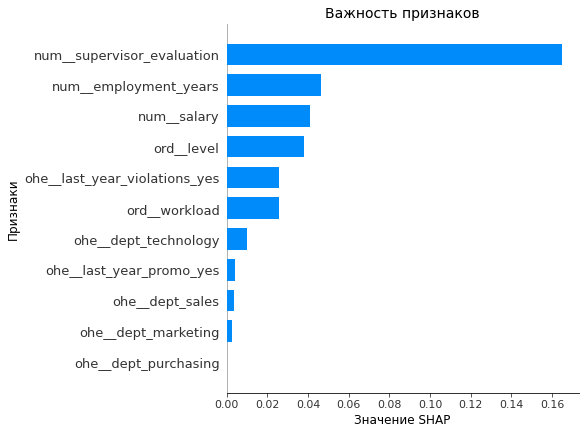

In [36]:
# оценим важность признаков
X_train_new = randomized_search.best_estimator_['preprocessor'].transform(X_train)

X_train_sample = shap.sample(X_train_new, 50) # 50 - количество примеров.

explainer = shap.PermutationExplainer(randomized_search.best_estimator_['models'].predict, X_train_sample)
    
labels = randomized_search.best_estimator_[:-1].get_feature_names_out()

shap_values = explainer(X_train_sample)
shap.summary_plot(shap_values, X_train_sample, plot_type='bar', feature_names=labels, show=False)

plt.xlabel("Значение SHAP", fontsize=12)
plt.ylabel("Признаки", fontsize=12)
plt.title("Важность признаков", fontsize=14)
plt.show() 

Наиболее значимым признаками являлись `supervisor_evaluation`, `emplymney_years` и `salary`.

In [37]:
# проверем на тестовой выборке
y_pred = randomized_search.predict(X_test)

print('Метрика SMAPE лучшей модели на тестовой выборке равна', round(smape(y_test, y_pred), 2))

Метрика SMAPE лучшей модели на тестовой выборке равна 13.79


## Вывод

Лучший показатель метрики SMAPE наблюдается у модели DecisionTreeRegressor с значением 13.79, что соответсвует критерию успеха (SMAPE ≤ 15 на тестовой выборке). Ее преимуществом является то, что она более легко справляется с моделированием нелинейных зависимостей между признаками и целевой переменной.

# Задача 2: предсказание увольнения сотрудника из компании

## Загрузка данных

Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

In [38]:
# загружаем данные
try:
    df_train_2 = pd.read_csv('/datasets/train_quit.csv')
    X_test_2 = pd.read_csv('/datasets/test_features.csv')
    y_test_2 = pd.read_csv('/datasets/test_target_quit.csv')
except:
    df_train_2 = pd.read_csv('train_quit.csv')
    X_test_2 = pd.read_csv('test_features.csv')
    y_test_2 = pd.read_csv('test_target_quit.csv')

**Вывод:** данные загружены.

## Предобработка данных

In [39]:
df_describe(df_train_2) 

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


Общая информация о полученном датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
Описание данных:


,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


Количество пустых значений:


id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Количество явных дубликатов:


0

In [40]:
# проверяем уникальные значения в строковых данных
columns = list(df_train_2.select_dtypes(include=['object']).columns)

for col in columns:
    print(df_train_2[col].unique())

['sales' 'purchasing' 'marketing' 'technology' 'hr']
['middle' 'junior' 'sinior']
['high' 'medium' 'low']
['no' 'yes']
['no' 'yes']
['no' 'yes']


In [41]:
# заменим некорректное значение 'sinior'
df_train_2['level'] = df_train_2['level'].replace('sinior', 'senior')
df_train_2['level'].value_counts()

junior    1949
middle    1694
senior     357
Name: level, dtype: int64

In [42]:
# установим id работника как индекс
df_train_2 = df_train_2.set_index('id')
df_train_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


In [43]:
df_describe(X_test_2) 

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


Общая информация о полученном датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
Описание данных:


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Количество пустых значений:


id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Количество явных дубликатов:


0

In [44]:
# проверяем уникальные значения в строковых данных
columns = list(X_test_2.select_dtypes(include=['object']).columns)

for col in columns:
    print(X_test_2[col].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
['junior' 'middle' 'sinior' nan]
['medium' 'low' 'high' ' ']
['no' 'yes']
['no' 'yes']


In [45]:
# заменим некорректное значение 'sinior'
X_test_2['level'] = X_test_2['level'].replace('sinior', 'senior')
X_test_2['level'].value_counts()

junior    974
middle    854
senior    171
Name: level, dtype: int64

In [46]:
# установим id работника как индекс
X_test_2 = X_test_2.set_index('id')
X_test_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [47]:
df_describe(y_test_2) 

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


Общая информация о полученном датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
Описание данных:


,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


Количество пустых значений:


id      0
quit    0
dtype: int64

Количество явных дубликатов:


0

In [48]:
# установим id работника как индекс
y_test_2 = y_test_2.set_index('id')
y_test_2.head()

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


**Вывод:** в тестовом датасете имеются несколько пустых значений в признаках `dept` и `level`. В соответсвии с заданием заполним даннные значения позже в пайплайне. В остальных датасетах проблем не отмечено.

## Исследовательский анализ данных

### Исследовательский анализ данных

Количество сотрудников по признаку "employment_years":


1     985
2     777
3     479
4     393
5     362
7     308
6     296
8     174
9     136
10     90
Name: employment_years, dtype: int64

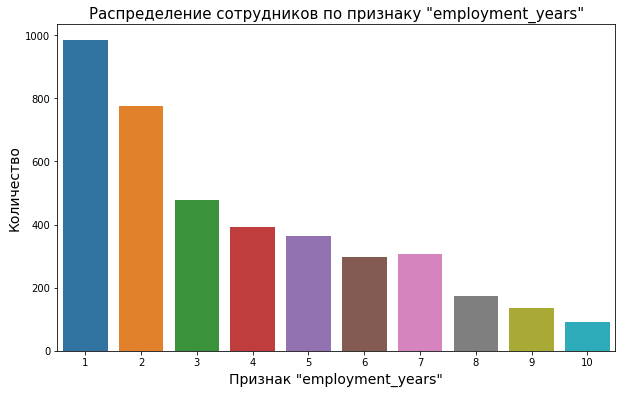

Количество сотрудников по признаку "supervisor_evaluation":


4    1654
3    1233
5     520
2     391
1     202
Name: supervisor_evaluation, dtype: int64

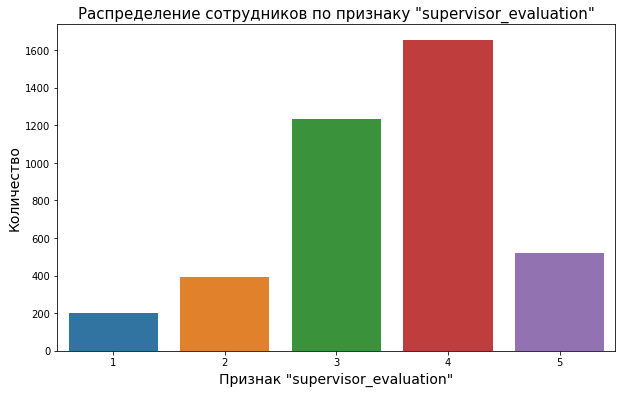

Описательная статистика для признака "salary":


count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

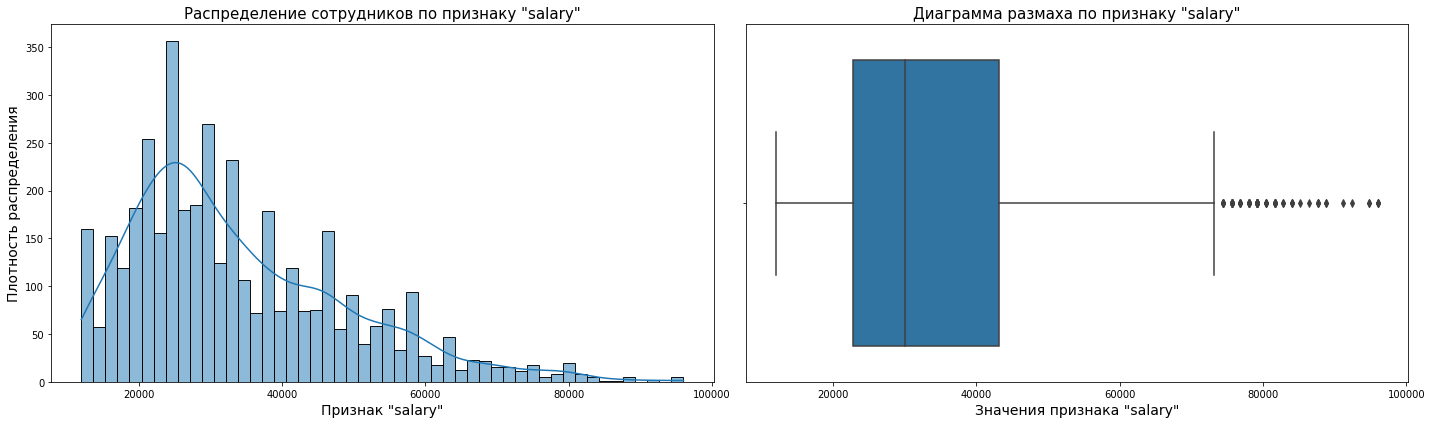

In [49]:
num_features = list(df_train_2.select_dtypes(exclude=['object']).columns)

for num in num_features:
    viz_col(df_train_2, num)

Количество сотрудников по признаку "dept":


sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

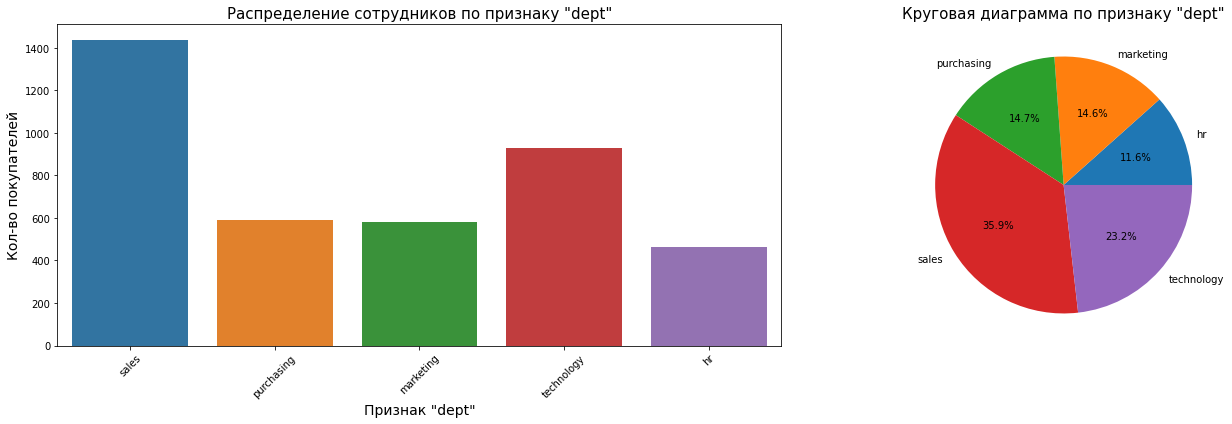

Количество сотрудников по признаку "level":


junior    1949
middle    1694
senior     357
Name: level, dtype: int64

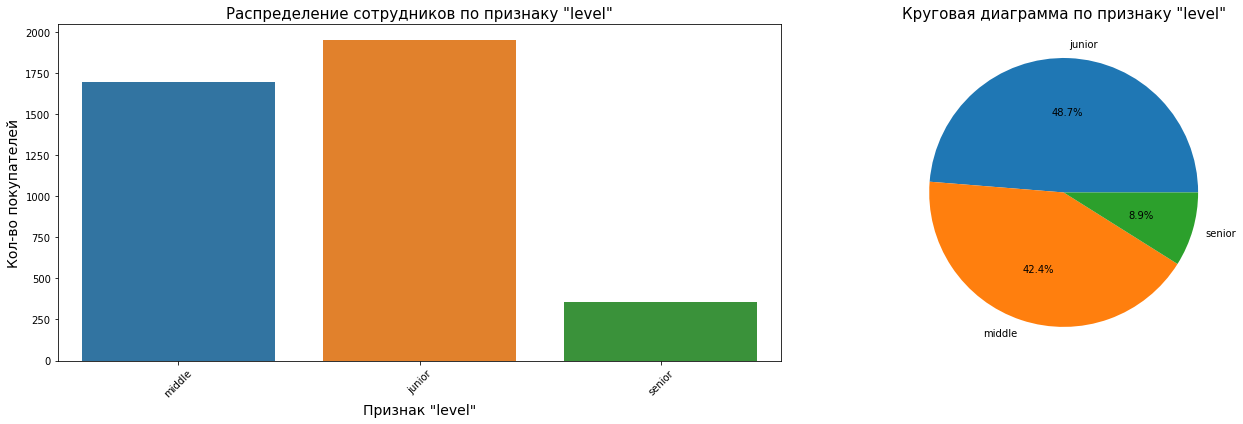

Количество сотрудников по признаку "workload":


medium    2118
low       1208
high       674
Name: workload, dtype: int64

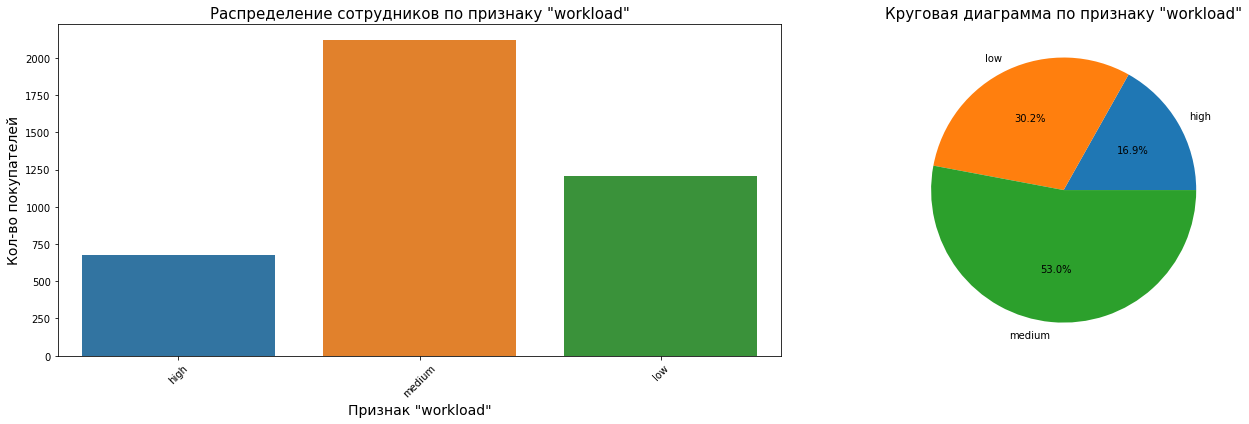

Количество сотрудников по признаку "last_year_promo":


no     3887
yes     113
Name: last_year_promo, dtype: int64

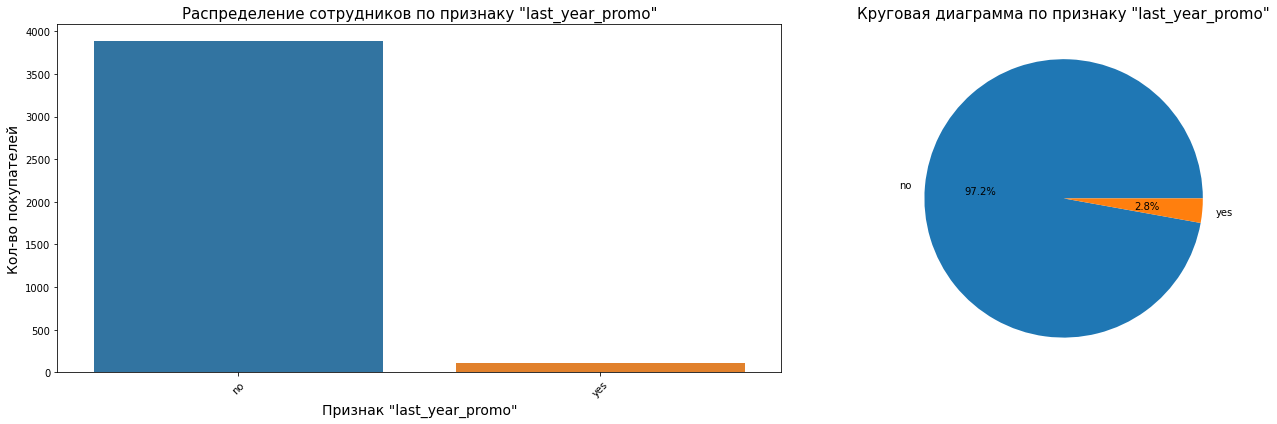

Количество сотрудников по признаку "last_year_violations":


no     3455
yes     545
Name: last_year_violations, dtype: int64

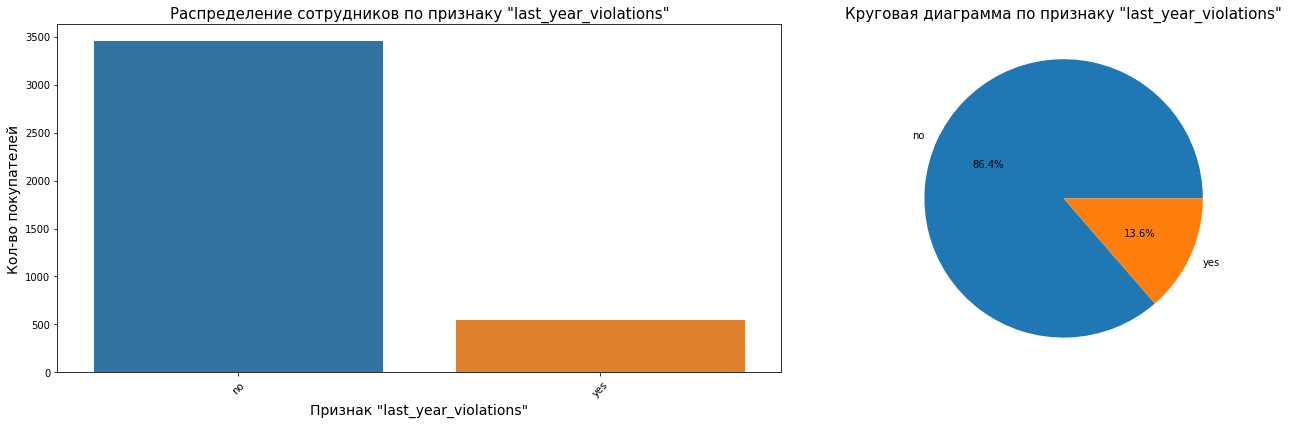

Количество сотрудников по признаку "quit":


no     2872
yes    1128
Name: quit, dtype: int64

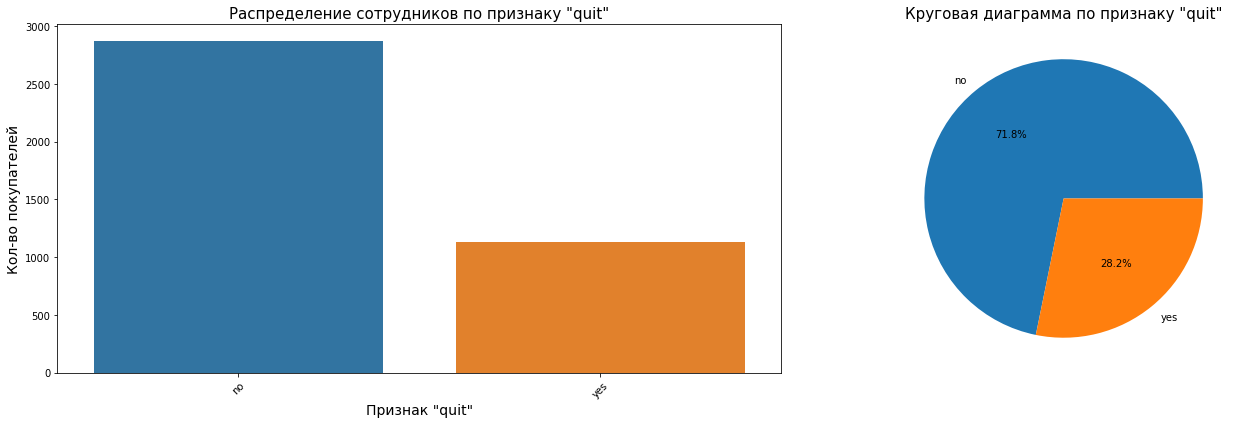

In [50]:
cat_features = list(df_train_2.select_dtypes(include=['object']).columns)

for cat in cat_features:
    viz_cat(df_train_2, cat)

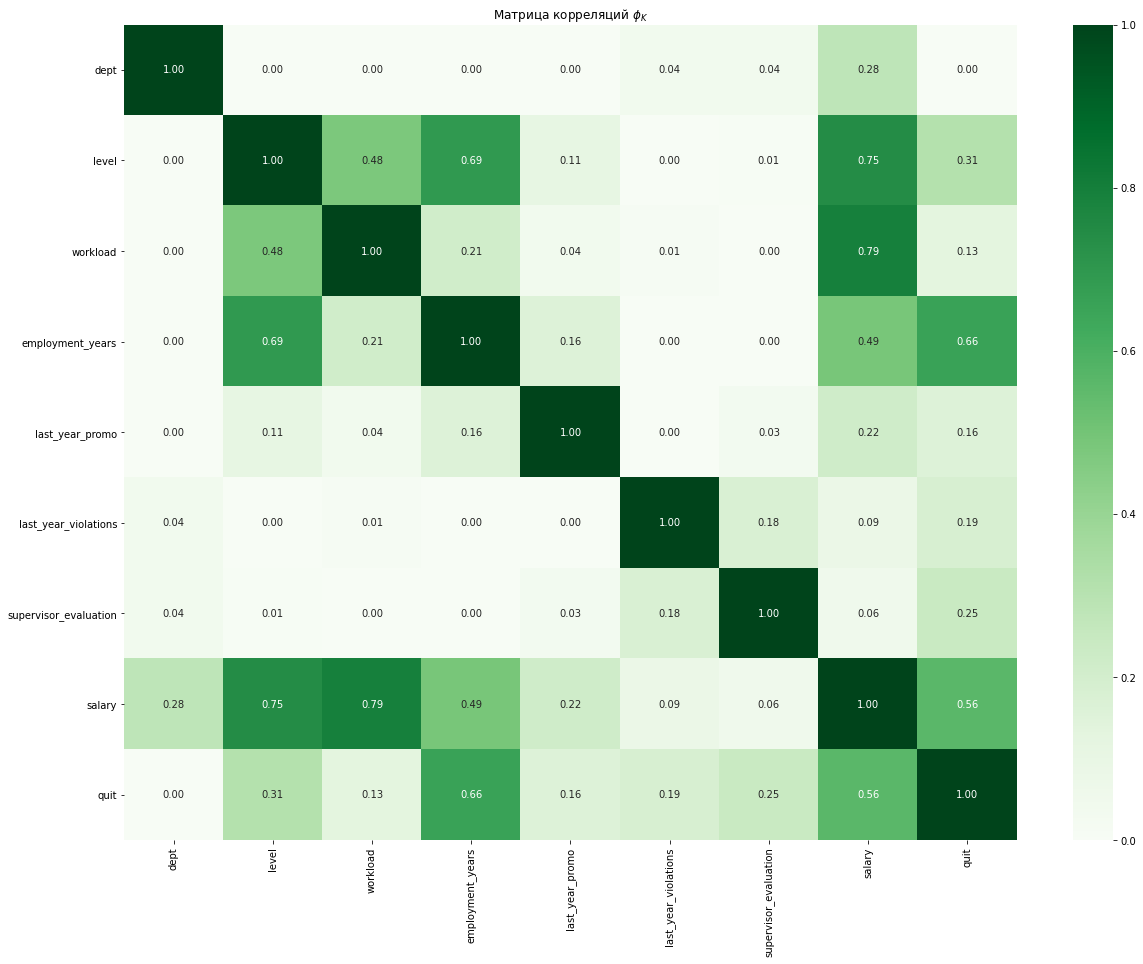

In [51]:
interval_cols = ['job_satisfaction_rate', 'salary']

corr_2 = df_train_2.phik_matrix(interval_cols=interval_cols, verbose=False)

plt.figure(figsize=(20, 15))  
sns.heatmap(corr_2, annot=True, cmap='Greens', fmt='.2f') 
plt.title('Матрица корреляций $\phi_K$')
plt.show()

Мультиколлинеарности не наббьюдается. Наибольшую корреляцию с целевым признаком имеют признаки - `employment_years` (0.66), `salary` (0.56) и `level` (0.31). 

In [52]:
# сопоставим тестовые данные для удобства визуализации и последующего обучения
df_test_2 = X_test_2.merge(y_test_2, on='id', how='left')
df_test_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no
686555,hr,junior,medium,1,no,no,4,30000,no
467458,sales,middle,low,5,no,no,4,19200,no
418655,sales,middle,low,6,no,no,4,19200,no
789145,hr,middle,medium,5,no,no,5,40800,no


Количество сотрудников по признаку "employment_years":


1     522
2     374
3     234
4     187
5     179
7     174
6     138
8      91
9      66
10     35
Name: employment_years, dtype: int64

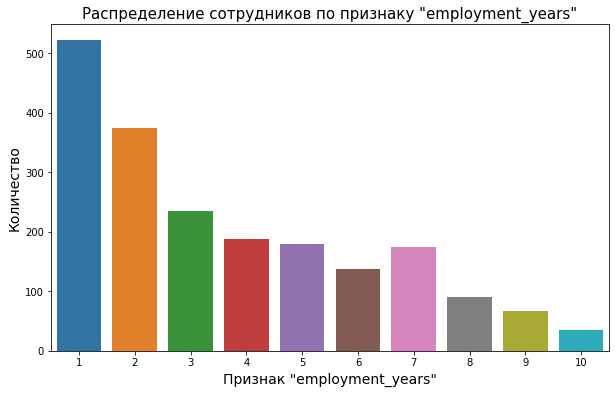

Количество сотрудников по признаку "supervisor_evaluation":


4    857
3    575
5    284
2    196
1     88
Name: supervisor_evaluation, dtype: int64

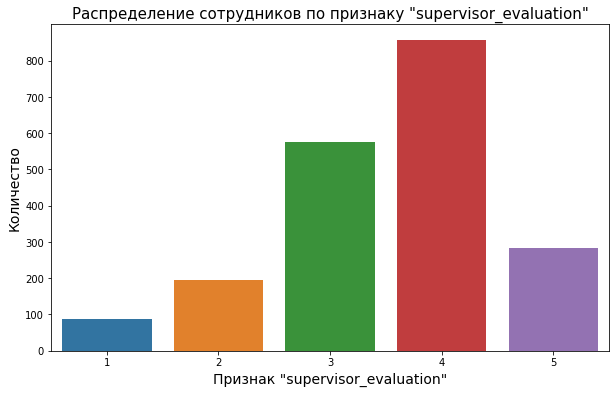

Описательная статистика для признака "salary":


count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

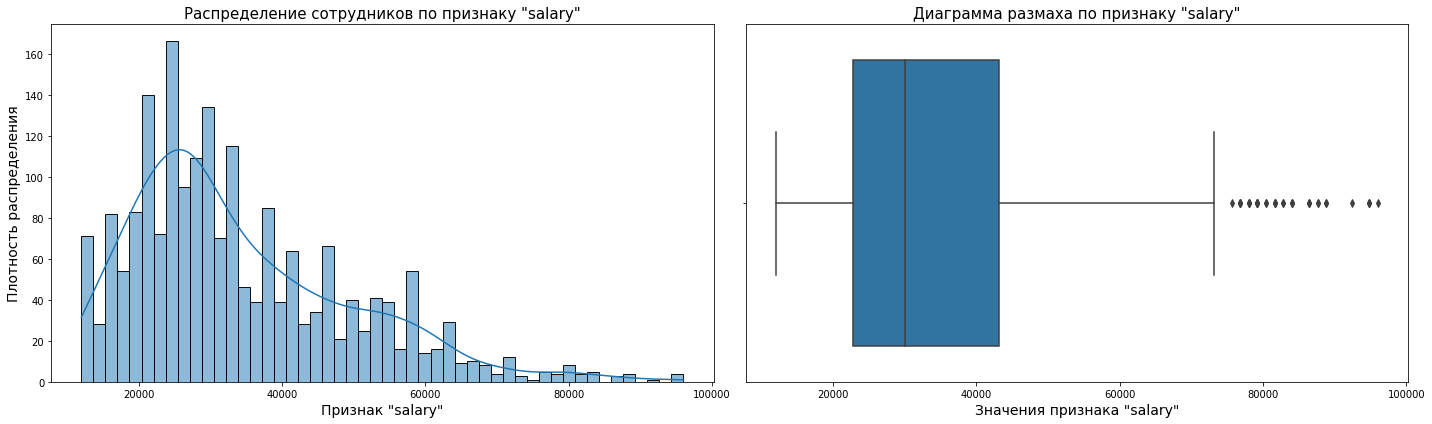

In [53]:
num_features = list(df_test_2.select_dtypes(exclude=['object']).columns)

for num in num_features:
    viz_col(df_test_2, num)

Количество сотрудников по признаку "dept":


sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

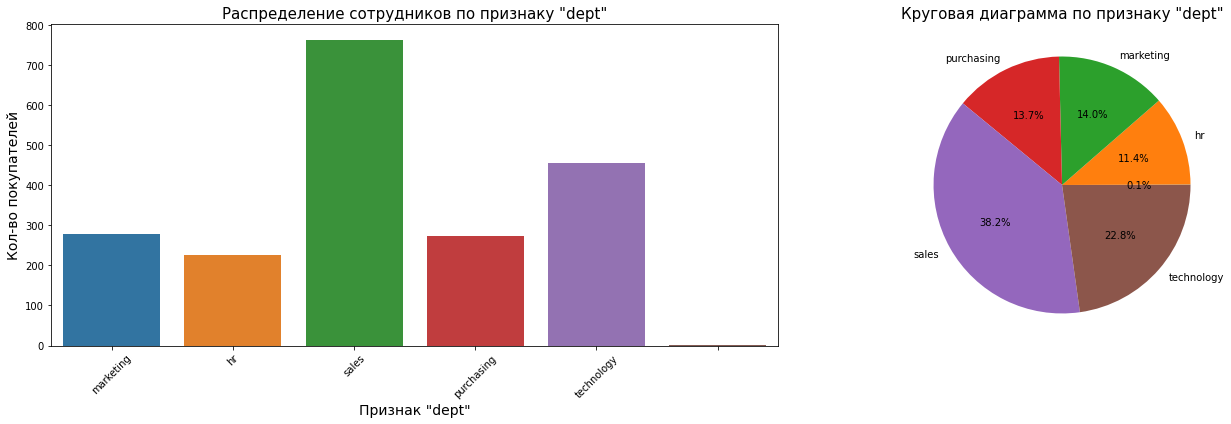

Количество сотрудников по признаку "level":


junior    974
middle    854
senior    171
Name: level, dtype: int64

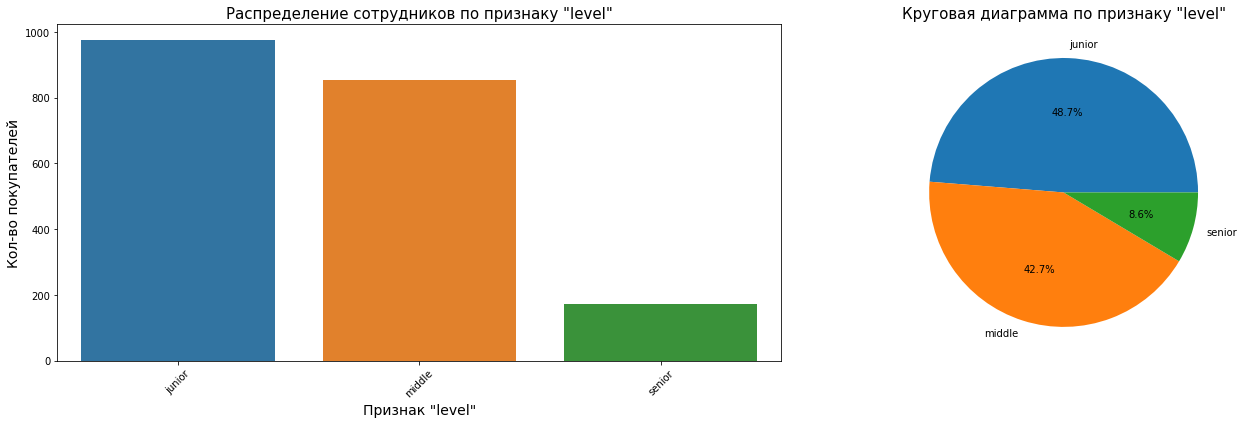

Количество сотрудников по признаку "workload":


medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

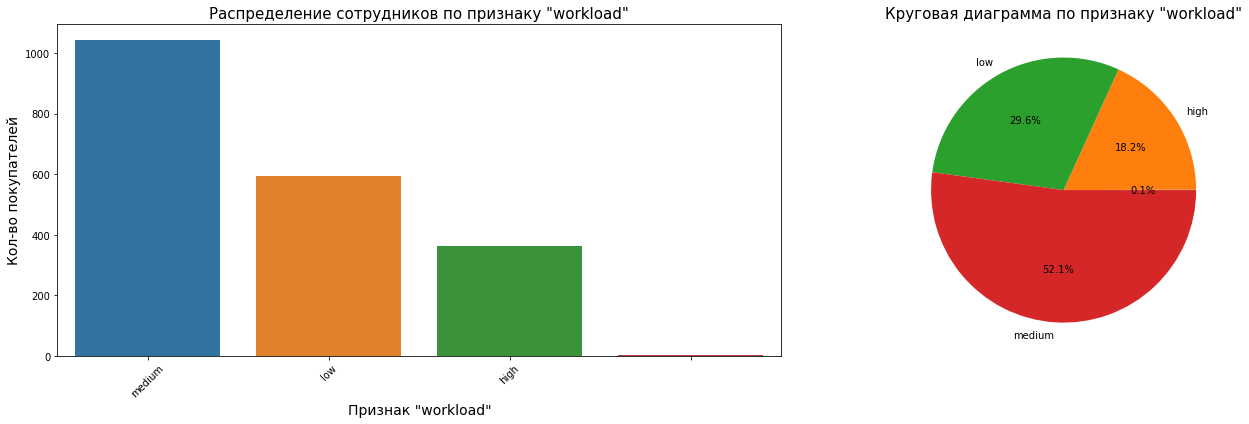

Количество сотрудников по признаку "last_year_promo":


no     1937
yes      63
Name: last_year_promo, dtype: int64

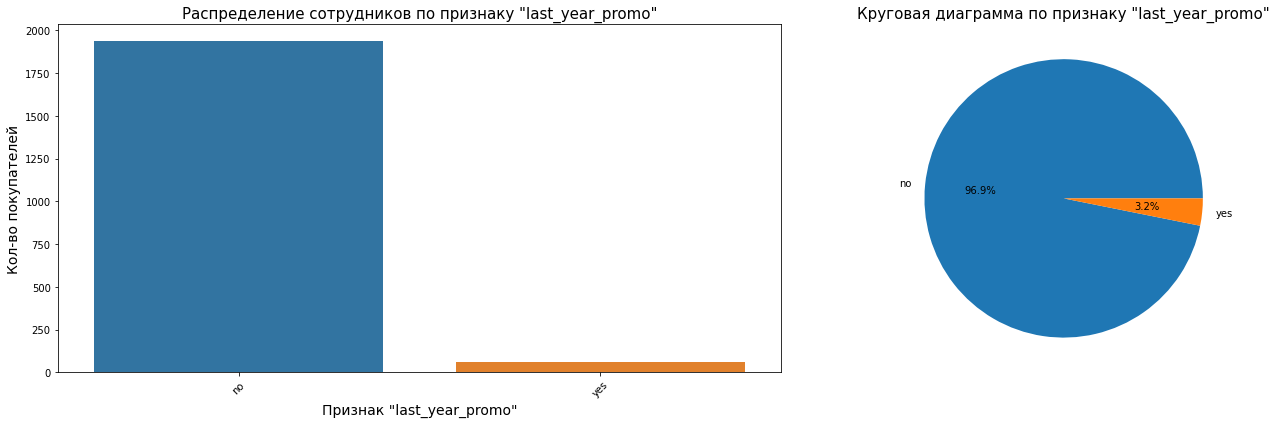

Количество сотрудников по признаку "last_year_violations":


no     1738
yes     262
Name: last_year_violations, dtype: int64

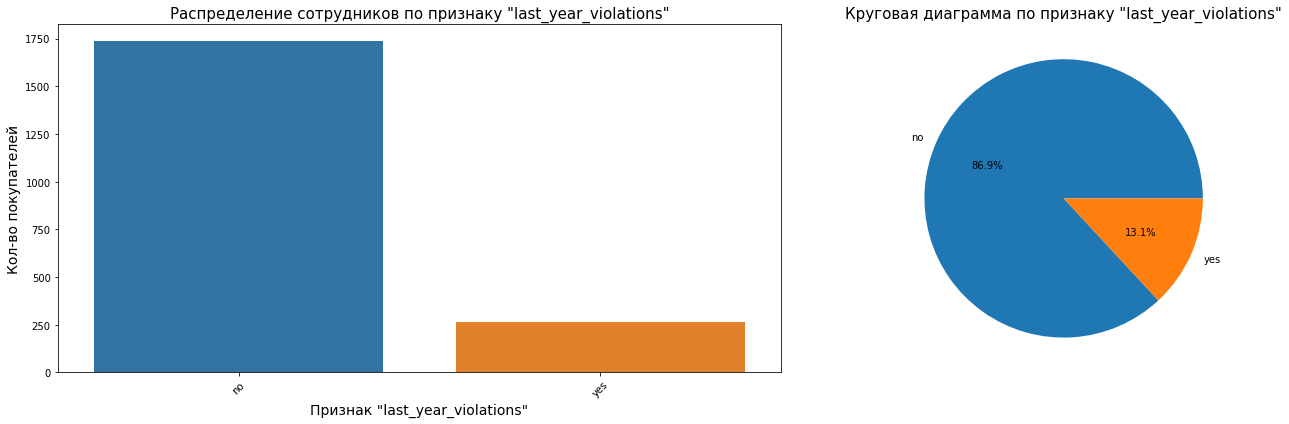

Количество сотрудников по признаку "quit":


no     1436
yes     564
Name: quit, dtype: int64

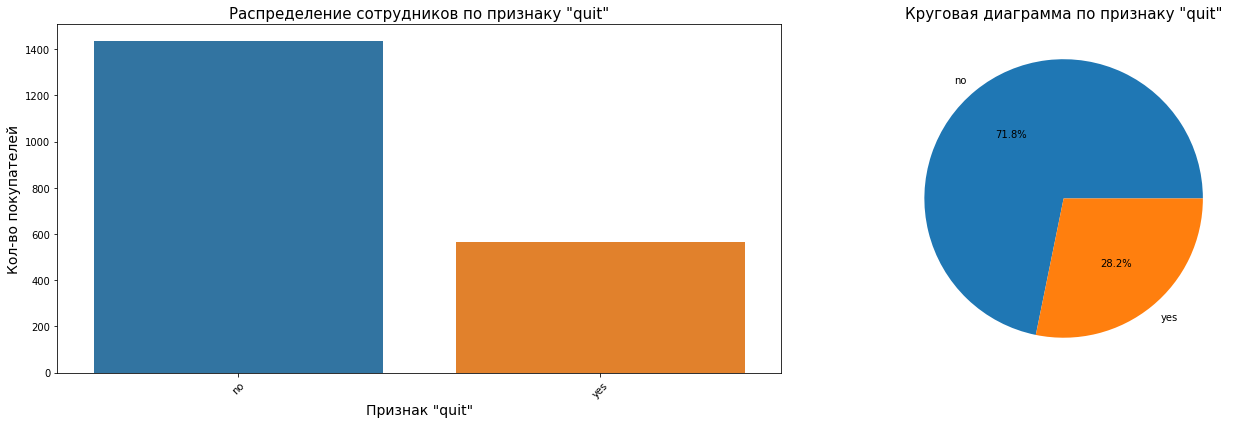

In [54]:
cat_features = list(df_test_2.select_dtypes(include=['object']).columns)

for cat in cat_features:
    viz_cat(df_test_2, cat)

**Вывод:** данные сопоставимы с данными из предыдущей задачи. Новый целевой признак `quit` - 28.2% сотрудников уволились (как в тренировочной, так и в тестовой выборках).

### Портрет уволившегося сотрудника

In [55]:
# разделим тренировочную выборку на уволившихся сотрудников и нет
df_quit = df_train_2.query('quit == "yes"')
df_not_quit = df_train_2.query('quit == "no"')

display(df_quit.head())
display(df_not_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
257132,sales,junior,medium,2,no,yes,3,24000,yes
699916,sales,junior,low,1,no,yes,3,18000,yes
613206,technology,middle,medium,2,no,no,3,45600,yes
468145,technology,junior,medium,2,no,no,3,30000,yes
982346,marketing,junior,medium,3,no,no,3,30000,yes


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
910140,marketing,junior,medium,2,no,no,5,25200,no
417070,technology,middle,medium,8,no,no,2,44400,no


In [56]:
# функция для сравнения количественных признаков уволившихся и оставшихся сотрудников
def viz_col_comparison(df_1, df_2, feature):
    print(f'Описательная статистика для признака "{feature}" уволившихся сотрудников:')
    display(df_1[feature].describe())
    print(f'Описательная статистика для признака "{feature}" оставшихся сотрудников:')
    display(df_2[feature].describe())
    
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df_1[feature], kde=True, bins=50)
    plt.title(f'Распределение уволившихся сотрудников по признаку "{feature}"', fontsize=15)
    plt.xlabel(f'Признак "{feature}"', fontsize=14)
    plt.ylabel('Плотность распределения', fontsize=14)
    
    
    plt.subplot(1, 2, 2)
    sns.histplot(df_2[feature], kde=True, bins=50)
    plt.title(f'Распределение оставшихся сотрудников по признаку "{feature}"', fontsize=15)
    plt.xlabel(f'Признак "{feature}"', fontsize=14)
    plt.ylabel('Плотность распределения', fontsize=14)
    
    plt.tight_layout()
    plt.show()

In [57]:
def viz_col_comparison(df_1, df_2, feature):
    discrete_features = [col for col in df_1.columns if df_1[col].nunique() < 20]
    continuous_features = [col for col in df_1.select_dtypes(include=['number']).columns if col not in discrete_features]
    

    if feature in discrete_features:
        print(f'Распределение уолившихся сотрудников по признаку "{feature}":')
        display(df_1[feature].value_counts())
        
        print(f'Распределение оставшихся сотрудников по признаку "{feature}":')
        display(df_2[feature].value_counts())
        
        print(f'Графики для дискретного признака "{feature}":')
        plt.figure(figsize=(20, 6))
        
        plt.subplot(1, 2, 1)
        sns.countplot(data=df_1, x=feature)
        plt.title(f'Распределение уволившихся сотрудников по признаку "{feature}"', fontsize=15)
        plt.xlabel(f'Признак "{feature}"', fontsize=14)
        plt.ylabel('Частота', fontsize=14)
        
        plt.subplot(1, 2, 2)
        sns.countplot(data=df_2, x=feature)
        plt.title(f'Распределение оставшихся сотрудников по признаку "{feature}"', fontsize=15)
        plt.xlabel(f'Признак "{feature}"', fontsize=14)
        plt.ylabel('Частота', fontsize=14)
        
        plt.tight_layout()
        plt.show()
    
    else:
        print(f'Описательная статистика для признака "{feature}" уволившихся сотрудников:')
        display(df_1[feature].describe())
        
        print(f'Описательная статистика для признака "{feature}" оставшихся сотрудников:')
        display(df_2[feature].describe())
        
        print(f'Графики для непрерывного признака "{feature}":')
        plt.figure(figsize=(20, 6))
        
        plt.subplot(1, 2, 1)
        sns.histplot(df_1[feature], kde=True, bins=50)
        plt.title(f'Распределение уволившихся сотрудников по признаку "{feature}"', fontsize=15)
        plt.xlabel(f'Признак "{feature}"', fontsize=14)
        plt.ylabel('Плотность распределения', fontsize=14)
        
        plt.subplot(1, 2, 2)
        sns.histplot(df_2[feature], kde=True, bins=50)
        plt.title(f'Распределение оставшихся сотрудников по признаку "{feature}"', fontsize=15)
        plt.xlabel(f'Признак "{feature}"', fontsize=14)
        plt.ylabel('Плотность распределения', fontsize=14)
        
        plt.tight_layout()
        plt.show()


In [58]:
# функция для сравнения категориальных признаков уволившихся и оставшихся сотрудников
def viz_cat_comparison(df_1, df_2, feature):
    print(f'Количество уволившихся сотрудников по признаку "{feature}":')
    display(df_1[feature].value_counts())
    print(f'Количество оставшихся сотрудников по признаку "{feature}":')
    display(df_2[feature].value_counts())
    
    plt.figure(figsize=(20, 6))
    
    plt.subplot(1, 2, 1)
    df_1.groupby(feature)[feature].count().plot(kind='pie', autopct='%.1f%%', subplots=True)
    plt.title(f'Круговая диаграмма по признаку "{feature}" для уволившихся сотрудников', fontsize=12)
    plt.ylabel("")

    
    plt.subplot(1, 2, 2)
    df_2.groupby(feature)[feature].count().plot(kind='pie', autopct='%.1f%%', subplots=True)
    plt.title(f'Круговая диаграмма по признаку "{feature}" для оставшихся сотрудников', fontsize=12)
    plt.ylabel("")
    
    plt.tight_layout()
    plt.show()

Распределение уолившихся сотрудников по признаку "employment_years":


1     599
2     290
3     163
4      27
5      23
6      10
7       7
8       3
9       3
10      3
Name: employment_years, dtype: int64

Распределение оставшихся сотрудников по признаку "employment_years":


2     487
1     386
4     366
5     339
3     316
7     301
6     286
8     171
9     133
10     87
Name: employment_years, dtype: int64

Графики для дискретного признака "employment_years":


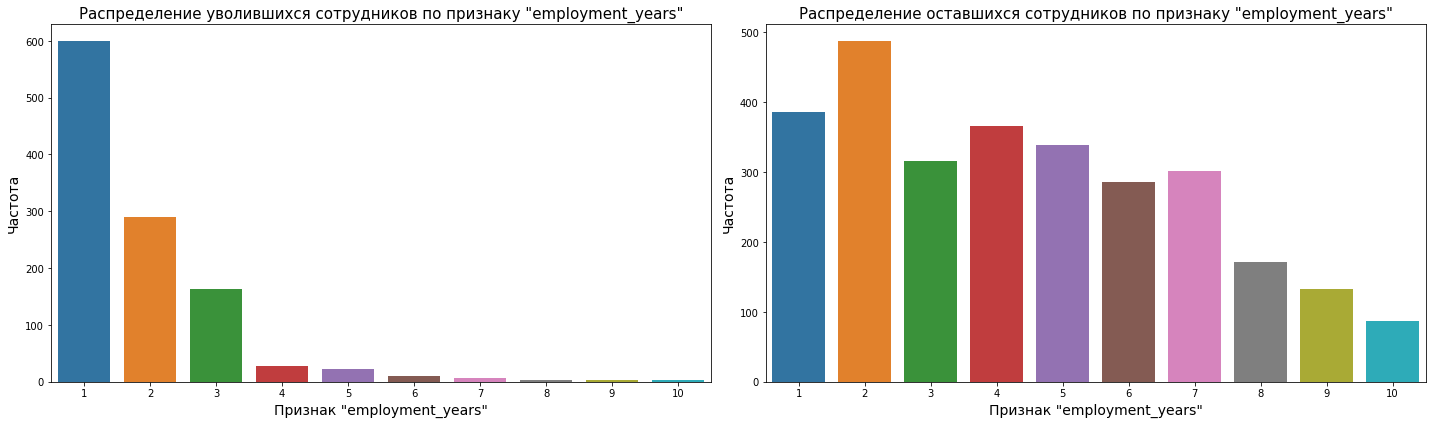

Распределение уолившихся сотрудников по признаку "supervisor_evaluation":


3    523
4    286
2    164
1     95
5     60
Name: supervisor_evaluation, dtype: int64

Распределение оставшихся сотрудников по признаку "supervisor_evaluation":


4    1368
3     710
5     460
2     227
1     107
Name: supervisor_evaluation, dtype: int64

Графики для дискретного признака "supervisor_evaluation":


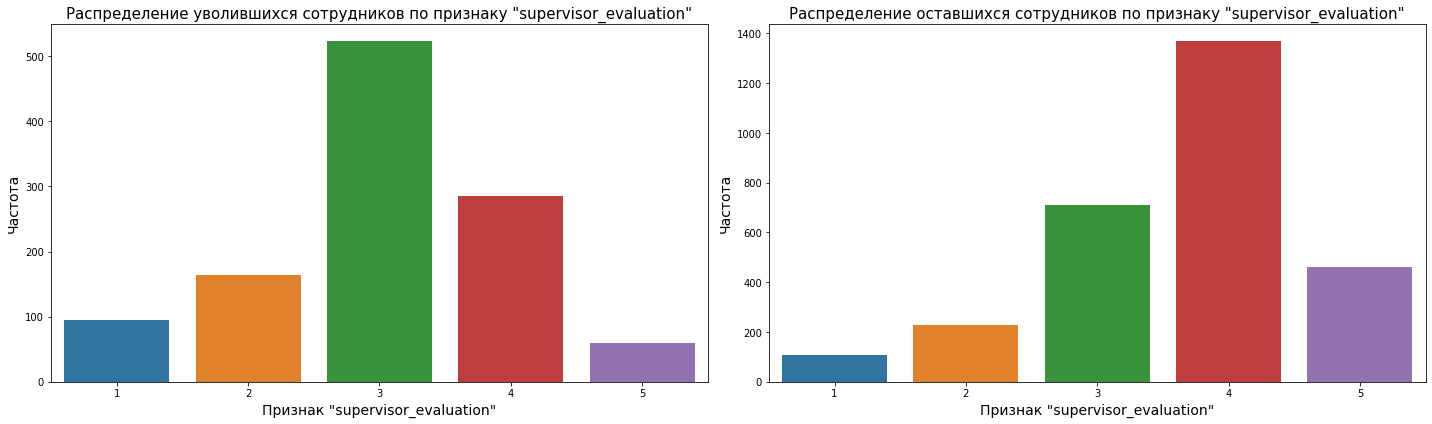

Описательная статистика для признака "salary" уволившихся сотрудников:


count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

Описательная статистика для признака "salary" оставшихся сотрудников:


count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64

Графики для непрерывного признака "salary":


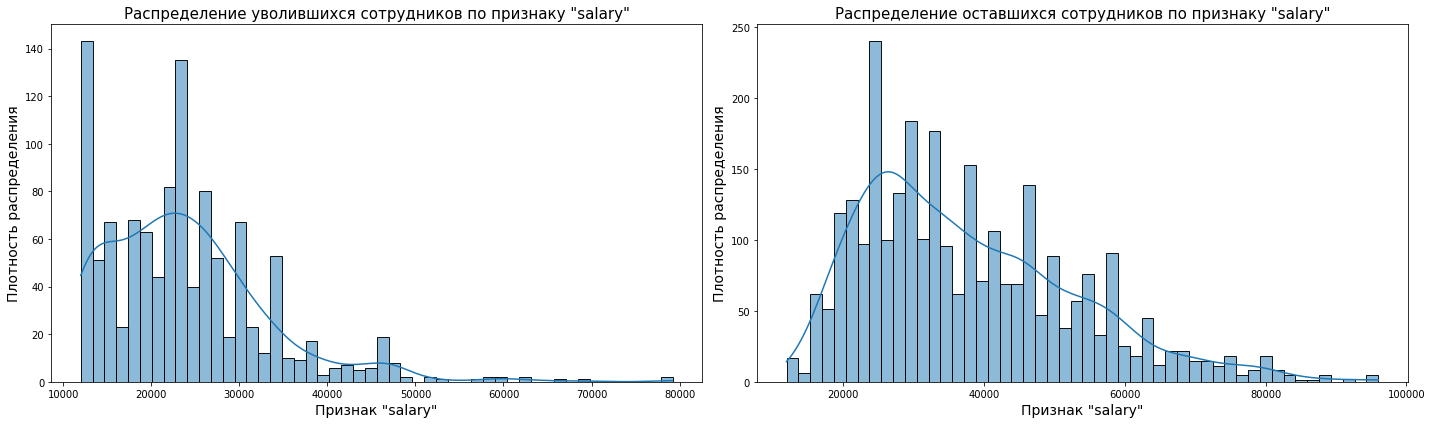

In [59]:
# смотрим портрет уволившегося сотрудника для количественных признаков
num_features = list(df_quit.select_dtypes(exclude=['object']).columns)

for num in num_features:
    viz_col_comparison(df_quit, df_not_quit, num)

Больше всего уволившихся сотрудников, которые проработали в компании менее 3 лет. Данные сотрудники в среднем получили оценку от начальника 3, в сравнении неуолившимися сотрудниками со средней оценкой 4. Средняя зарплата в группе уволившихся сотрудников была меньше чем в группе оставшихся (23885 и 37702, соответсвенно).

Количество уволившихся сотрудников по признаку "dept":


sales         407
technology    276
purchasing    166
marketing     163
hr            116
Name: dept, dtype: int64

Количество оставшихся сотрудников по признаку "dept":


sales         1031
technology     652
purchasing     422
marketing      419
hr             348
Name: dept, dtype: int64

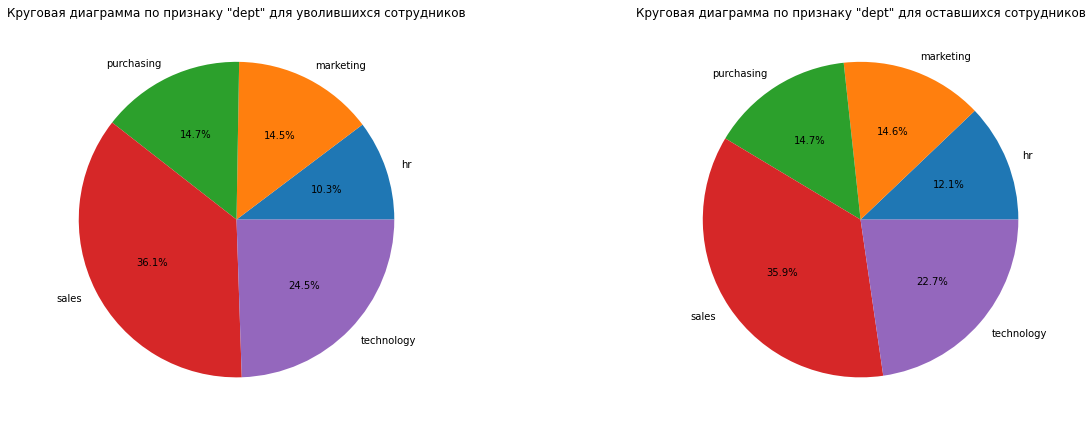

Количество уволившихся сотрудников по признаку "level":


junior    1003
middle     108
senior      17
Name: level, dtype: int64

Количество оставшихся сотрудников по признаку "level":


middle    1586
junior     946
senior     340
Name: level, dtype: int64

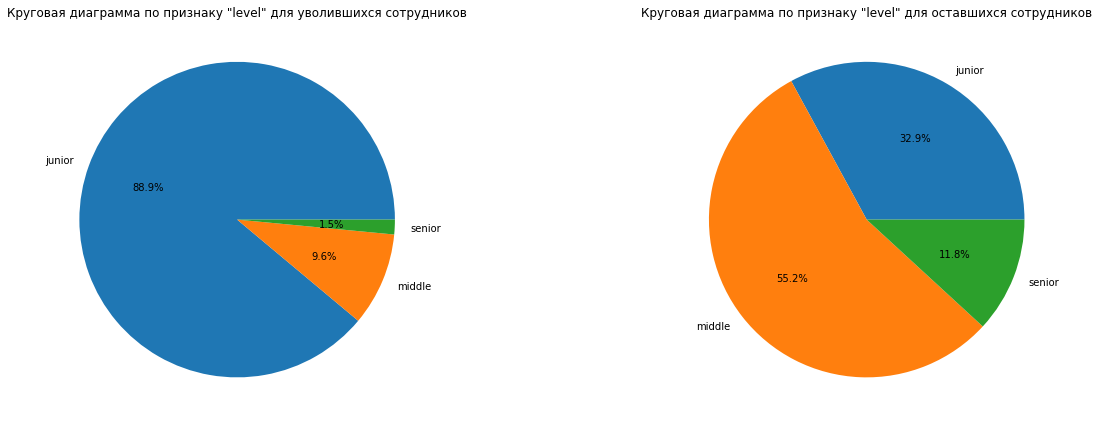

Количество уволившихся сотрудников по признаку "workload":


low       519
medium    488
high      121
Name: workload, dtype: int64

Количество оставшихся сотрудников по признаку "workload":


medium    1630
low        689
high       553
Name: workload, dtype: int64

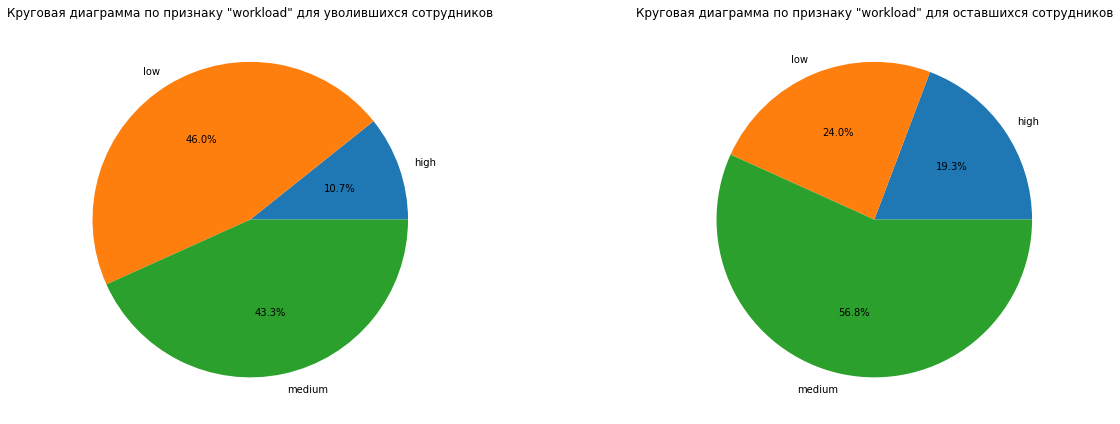

Количество уволившихся сотрудников по признаку "last_year_promo":


no     1127
yes       1
Name: last_year_promo, dtype: int64

Количество оставшихся сотрудников по признаку "last_year_promo":


no     2760
yes     112
Name: last_year_promo, dtype: int64

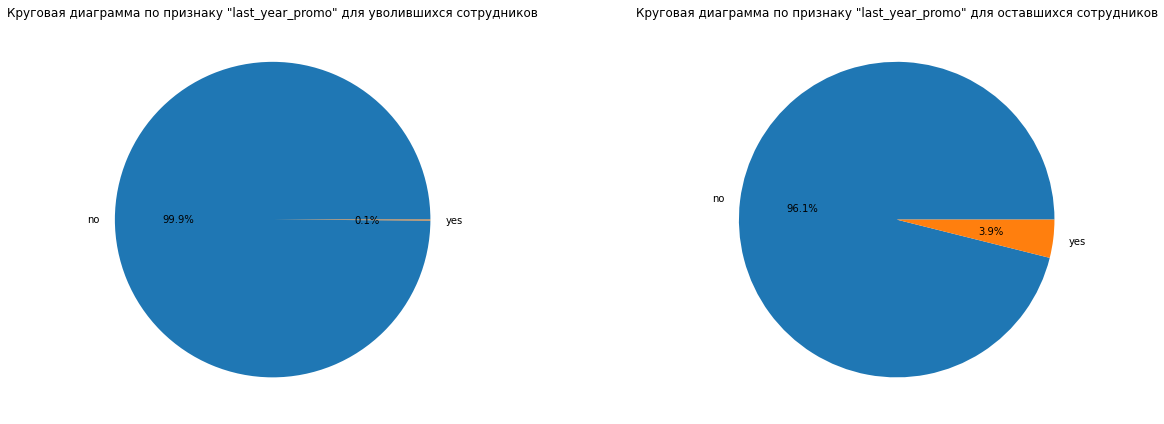

Количество уволившихся сотрудников по признаку "last_year_violations":


no     900
yes    228
Name: last_year_violations, dtype: int64

Количество оставшихся сотрудников по признаку "last_year_violations":


no     2555
yes     317
Name: last_year_violations, dtype: int64

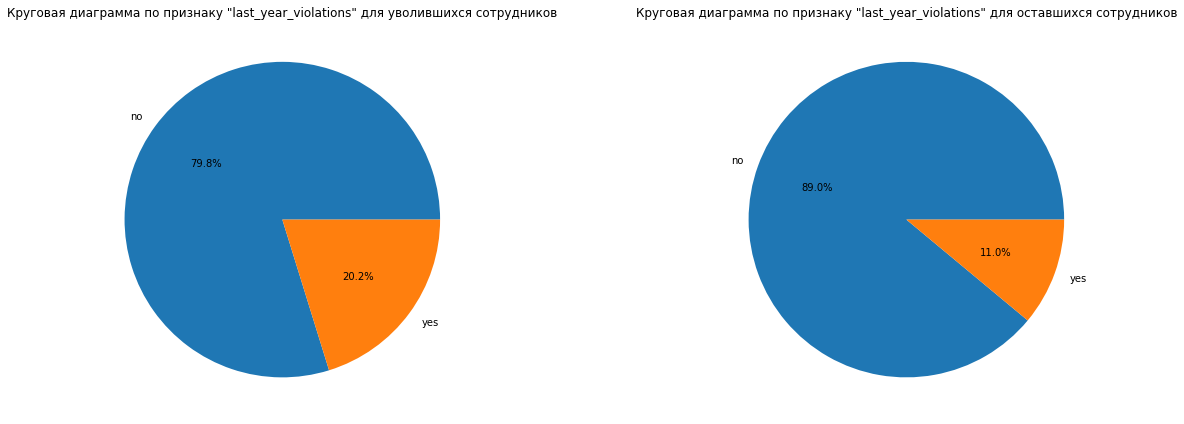

In [60]:
# смотрим портрет уволившегося сотрудника для качественных признаков
cat_features = list(df_quit.select_dtypes(include=['object']).columns)
cat_features.remove('quit')

for cat in cat_features:
    viz_cat_comparison(df_quit, df_not_quit, cat)

Больше всего сотрудников ушло из отдела продаж. Сотрудники уровня 'junior' чаще увольнялись по сравнению с более высокими уровнями. У большиства уволившихся сотрудников уровен нагрузки был низким. Только 1 из 1128 уволившихся сотрудников получил повышение  в прошлом году. Большинство сотрудников не нарушали договор за последний год.

### Влияние уровеня удовлетворённости сотрудника

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

In [61]:
df_y_test = pd.concat([y_test, y_test_2], axis=1)
df_y_test.head()

,job_satisfaction_rate,quit
id,,
100298,0.80,no
100480,0.84,no
100503,0.79,no
100610,0.75,no
100692,0.69,no


In [62]:
df_y_test_quit = df_y_test.query('quit == "yes"')
df_y_test_not_quit = df_y_test.query('quit == "no"')

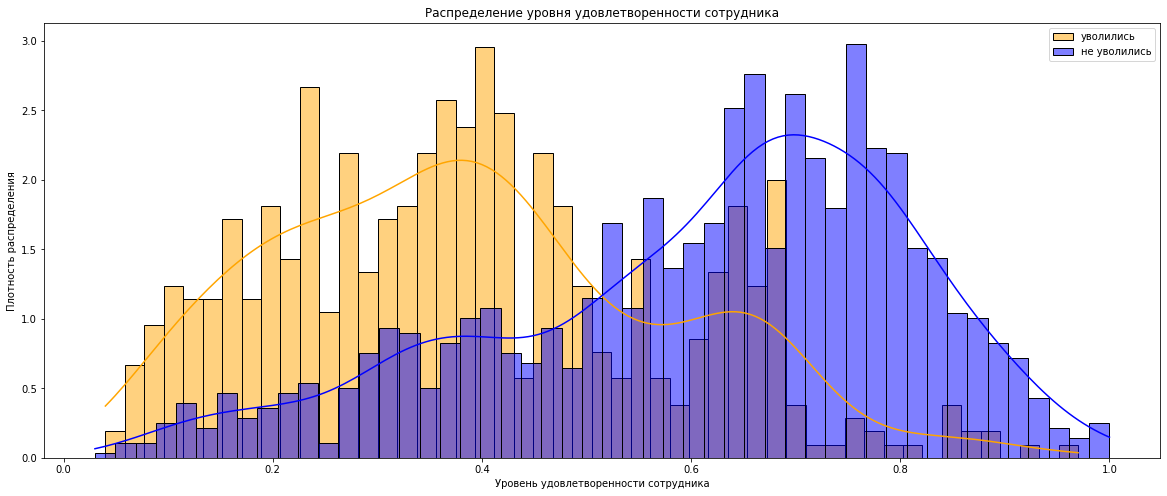

In [63]:
plt.figure(figsize=(20, 8))
bins = 50
sns.histplot(data=df_y_test_quit,
             x='job_satisfaction_rate',stat='density', 
             common_norm=False,
             kde=True,
             color='orange',
             bins=bins,
             alpha=0.5,
             label='уволились')

sns.histplot(data=df_y_test_not_quit,
             x='job_satisfaction_rate',
             stat='density', 
             common_norm=False,
             kde=True,
             color='blue',
             bins=bins,
             alpha=0.5, 
             label='не уволились')

plt.ylabel('Плотность распределения')
plt.xlabel('Уровень удовлетворенности сотрудника')
plt.title('Распределение уровня удовлетворенности сотрудника')
plt.legend();

Утверждение аналитиков верно - уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. На визуализации выше, можно увидеть, что сотрудники увольнялись чаще, если уровень удовлетворенности был ниже 0.5.

## Добавление нового входного признака

Допустим, job_satisfaction_rate и quit действительно связаны и вы получили необходимое значение метрики в первой задаче. Тогда добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [64]:
# job_satisfaction_rate, предсказанный лучшей моделью первой задачи, для тренировочной выборки
df_train_2['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(df_train_2.drop(['quit'], axis=1))
df_train_2.sample(10)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
644634,sales,junior,medium,1,no,yes,2,26400,yes,0.145333
843634,hr,junior,medium,3,no,no,4,30000,no,0.836000
289921,marketing,senior,high,9,yes,no,4,70800,no,0.840000
683530,sales,junior,medium,1,no,no,1,24000,yes,0.348750
387758,marketing,junior,low,2,no,no,4,18000,no,0.818571
979410,hr,senior,low,5,no,no,1,32400,no,0.370909
636550,purchasing,junior,medium,3,no,no,3,25200,yes,0.470909
893812,sales,junior,medium,2,no,no,3,27600,no,0.493077
340978,sales,junior,medium,4,no,no,2,24000,no,0.498182


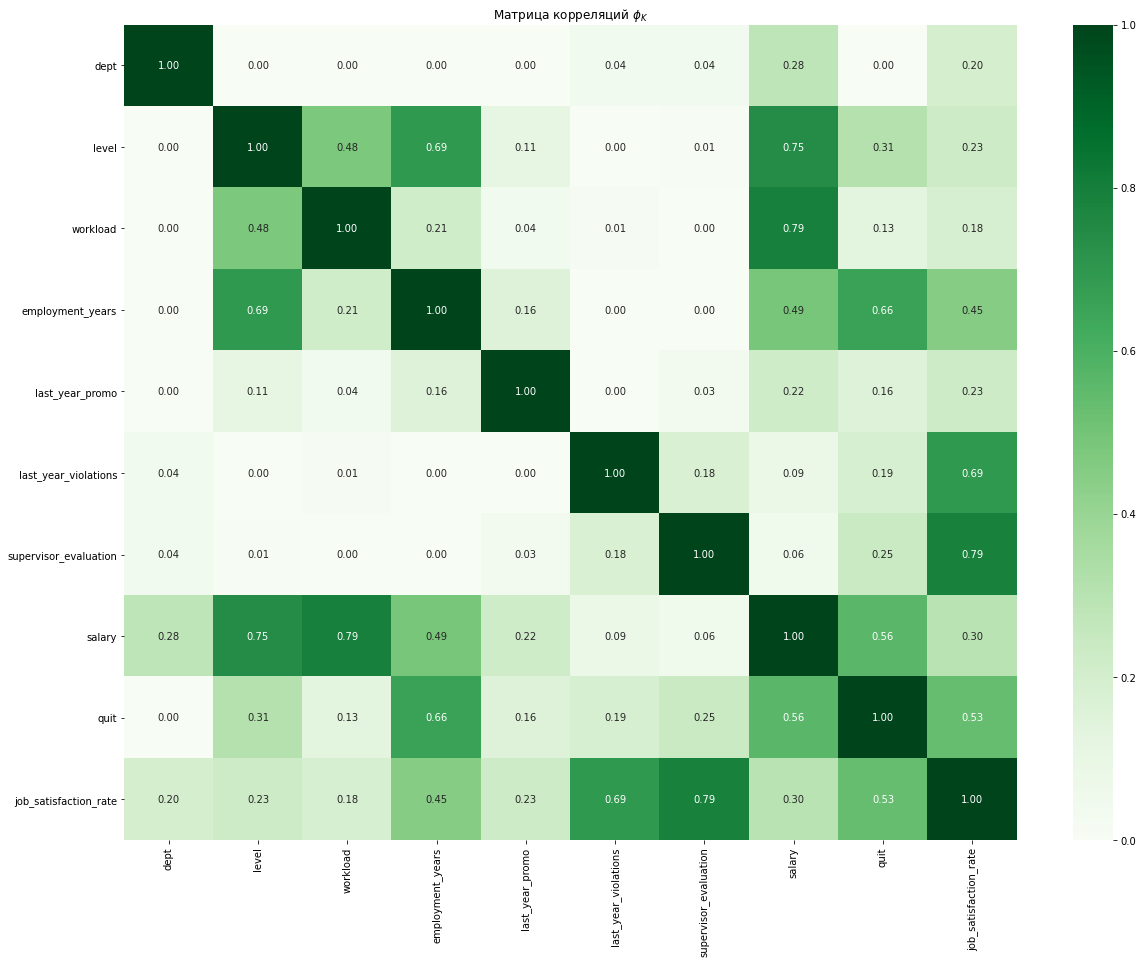

In [65]:
interval_cols = ['job_satisfaction_rate', 'salary']

corr_3 = df_train_2.phik_matrix(interval_cols=interval_cols, verbose=False)

plt.figure(figsize=(20, 15))  
sns.heatmap(corr_3, annot=True, cmap='Greens', fmt='.2f') 
plt.title('Матрица корреляций $\phi_K$')
plt.show()

Новый входной признак `job_satisfaction_rate` коррелирует с целевым признаком (0.51).

In [66]:
# job_satisfaction_rate, предсказанный лучшей моделью первой задачи, для тестовой выборки
df_test_2['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(df_test_2.drop(['quit'], axis=1))
df_test_2.sample(10)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
132583,marketing,middle,low,5,no,no,2,30000,no,0.480000
379954,sales,middle,high,8,no,no,4,49200,no,0.648000
131414,purchasing,middle,low,6,no,no,1,18000,no,0.346364
684188,hr,junior,medium,1,no,no,3,25200,yes,0.269167
611939,sales,junior,low,3,no,yes,3,18000,yes,0.263571
557985,sales,junior,high,1,no,no,4,34800,no,0.760000
854944,hr,junior,low,2,no,no,4,13200,yes,0.661000
493196,sales,junior,low,1,no,no,4,12000,yes,0.521200
538113,marketing,junior,medium,2,no,no,4,24000,no,0.673333


**Вывод:** в тренировочную и тестовую выборки добавлен новый входной признак, предсказанный лучшей моделью из предыдущей задачи.

## Подготовка данных

In [67]:
X_train = df_train_2.drop(['quit'], axis=1)
y_train = df_train_2['quit']

X_test = df_test_2.drop(['quit'], axis=1)
y_test = df_test_2['quit']

display(X_train.head())
display(y_train.head())
display(X_test.head())
display(y_test.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.635385
814010,sales,junior,medium,2,no,no,4,27600,0.826111
155091,purchasing,middle,medium,5,no,no,1,37200,0.366667
257132,sales,junior,medium,2,no,yes,3,24000,0.358750
910140,marketing,junior,medium,2,no,no,5,25200,0.786667


id
723290     no
814010     no
155091     no
257132    yes
910140     no
Name: quit, dtype: object

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.852308
686555,hr,junior,medium,1,no,no,4,30000,0.676667
467458,sales,middle,low,5,no,no,4,19200,0.720625
418655,sales,middle,low,6,no,no,4,19200,0.686250
789145,hr,middle,medium,5,no,no,5,40800,0.839286


id
485046    no
686555    no
467458    no
418655    no
789145    no
Name: quit, dtype: object

In [68]:
# кодирование целевого признака
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

display(y_train)
display(y_test)

array([0, 0, 0, ..., 1, 0, 1])

array([0, 0, 0, ..., 1, 0, 0])

In [69]:
# определим списки для кодирования
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

num_columns = ['employment_years', 'salary','supervisor_evaluation', 'job_satisfaction_rate']

ord_columns = ['level', 'workload']

In [70]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )


# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)


# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer([
    ('ohe',ohe_pipe,ohe_columns),
    ('ord',ord_pipe,ord_columns),
    ('num',StandardScaler(),num_columns)
],
remainder='passthrough')

**Вывод:** выборки разделены с учетом целевого признака. Создан пайплайн для подготовки данных.

## Обучение моделей

In [71]:
# создаём пайплайн: подготовка данных и модель
pipe_final = Pipeline(
[
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

In [72]:
RANDOM_STATE = 42

# словарь гиперпараметров
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'models__min_samples_leaf': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    #Словарь для SVC(non-poly)
    {
        'models' : [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel' : ['linear', 'rbf', 'sigmoid'],
        'preprocessor__num' : [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        
    }
]

In [73]:
# автоматический подбор с помощью RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [74]:
# ищем наилучшую модель
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Параметры наилучшей модели:\n\n', randomized_search.best_params_)

probabilities = randomized_search.predict_proba(X_test) 
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

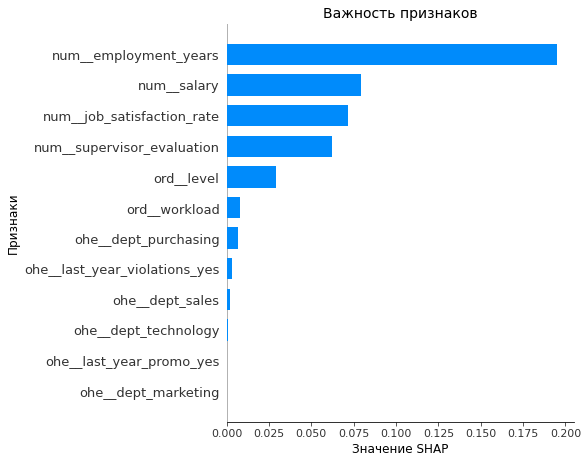

In [75]:
# оценка важности признаков
X_train_new = randomized_search.best_estimator_['preprocessor'].transform(X_train)
X_train_sample = shap.sample(X_train_new, 50) # 50 - количество примеров.
explainer = shap.PermutationExplainer(randomized_search.best_estimator_['models'].predict_proba, X_train_sample)
    
labels = randomized_search.best_estimator_[:-1].get_feature_names_out()

shap.summary_plot(explainer.shap_values(X_train_sample)[..., 1], X_train_sample, plot_type='bar', feature_names=labels, show=False)

plt.xlabel("Значение SHAP", fontsize=12)
plt.ylabel("Признаки", fontsize=12)
plt.title("Важность признаков", fontsize=14)
plt.show() 

**Вывод:** наилучший результат показала модель DecisionTreeClassifier с гиперпараметрами max_depth=6, max_features=7, min_samples_leaf=13. Метрика ROC-AUC составила 0.92 (критерий успеха согласно уссловиям задачи ROC-AUC ≥ 0.91 на тестовой выборке). Такой резкльтат вероятно обусловлентем, что преимуществом данной модели является то, что она более легко справляется с моделированием нелинейных зависимостей между признаками и целевой переменной. Наиболее важными признаками являлись `employment_years`, `salary`, `ssatisfaction_rate`, `supervisor_evaluation` и `level`.

## Итоговый вывод

**Задача 1. Построение модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.**

В ходе работы над задачей:
* Данные были загружены
* Названия столбцов и значения признаков записаны в соответсвии с PEP8. Все типы данных соответсвуют значениям. Имеются несколько пропусков в признаках `dept` (6) и `level` (4). В соответсвии с требованиями заполним данные пропуски поздней в пайплайне. Явные и неявные дубликаты отсутсвуют. Исправлена опечатка в уровне сотрудника. id сотрудника установлен как индекс. В датасете test_target_job_satisfaction_rate аномалий не отмечено.
* Установлено, что больше всего сотрудников наблюдается в отделе продаж. Сотрудник уровня 'junior' больше всего. Среднее количество нагрузки отмечено у 2066 сотрудников. Повышение за последний год получили 120 сотрудников (3%). 449 человек (14%) нарушали трудовой договор за последний год. Мультиколлинеарности не наблюдается. С целевым признаком имеют корреляцию такие признаки как `supervisor_evaluation` (0.76), `last_year_violations` (0.56), `employment_years` (0.33)  и `last_year_promo` (0.19). Значения признаков в тестовой обучающей выборке схожи с тренировочными данными. В соответсвии с тетовой выборкой 564 сотрудника (28.2%) покинули компанию.
* Был создан пайплайн для подготовки данных.
* Был найден лучший показатель метрики SMAPE, который наблюдается у модели DecisionTreeRegressor с значением 13.79, что соответсвует критерию успеха (SMAPE ≤ 15 на тестовой выборке). Ее преимуществом является то, что она более легко справляется с моделированием нелинейных зависимостей между признаками и целевой переменной.

**Задача 2. Построение модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компани.**

В ходе работы над задачей:
* Данные были загруженs и изучены. В тестовом датасете имеются несколько пустых значений в признаках `dept` и `level`. В соответсвии с заданием заполним даннные значения позже в пайплайне. В остальных датасетах проблем не отмечено.
* Данные сопоставимы с данными из предыдущей задачи. Новый целевой признак `quit` - 28.2% сотрудников уволились (как в тренировочной, так и в тестовой выборках).
* Был составлен портрет уволившегося сотрудника: больше всего уволившихся сотрудников, которые проработали в компании менее 3 лет. Данные сотрудники в среднем получили оценку от начальника 3, в сравнении неуолившимися сотрудниками со средней оценкой 4. Средняя зарплата в группе уволившихся сотрудников была меньше чем в группе оставшихся (23885 и 37702, соответсвенно). Больше всего сотрудников ушло из отдела продаж. Сотрудники уровня 'junior' чаще увольнялись по сравнению с более высокими уровнями. У большиства уволившихся сотрудников уровен нагрузки был низким. Только 1 из 1128 уволившихся сотрудников получил повышение  в прошлом году. Большинство сотрудников не нарушали договор за последний год.
* Было установлено, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. На визуализации выше, можно увидеть, что сотрудники увольнялись чаще, если уровень удовлетворенности был ниже 0.5.
* В тренировочную и тестовую выборки добавлен новый входной признак, предсказанный лучшей моделью из предыдущей задачи.
* Выборки разделены с учетом целевого признака. Создан пайплайн для подготовки данных.
* Наилучший результат показала модель DecisionTreeClassifier с гиперпараметрами max_depth=6, max_features=7, min_samples_leaf=13. Метрика ROC-AUC составила 0.92 (критерий успеха согласно уссловиям задачи ROC-AUC ≥ 0.91 на тестовой выборке). Такой резкльтат вероятно обусловлентем, что преимуществом данной модели является то, что она более легко справляется с моделированием нелинейных зависимостей между признаками и целевой переменной. Наиболее важными признаками являлись `employment_years`, `salary`, `satisfaction_rate`, `supervisor_evaluation` и `level`.

**Рекомендации:**
чтобы понять, собирается ли сотрудник уволиться, можно использовать показатель уровня его удовлетворенности работой (предсказанный `job_satisfaction_rate`). Важно обратить внимание на сотрудников уроня 'junior', которые чаще всего покидают компанию (вероятно в виду низких зарплат и отсутсвия повышений и перспектив). Рекомендуется тщательно проанализировать систему оплаты труда и повышения для данных сотрудников в течение года. Это позволит выявить возможные недостатки и улучшить условия работы, что, в свою очередь, может способствовать удержанию молодых специалистов и повышению их лояльности к компании.